In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("drive/MyDrive/Colab Notebooks/CERN Project 2022/Generated.csv", delimiter=' ', header=None)

Mounted at /content/drive


In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.sum(axis=1)

0       6.507204
1       7.995110
2       1.494364
3       7.881509
4       6.515179
          ...   
4995    7.499999
4996    8.258948
4997    8.674765
4998    4.155492
4999    6.995077
Length: 5000, dtype: float64

In [5]:
def build_generator():
    #Initializing a neural network
    generator = Sequential()
    
    #Adding an Input layer to the network
    generator.add(Dense(units=256, input_dim=121))    

    #Activating the layer with LeakyReLU activation function
    generator.add(LeakyReLU(0.2))

    #Applying Batch Normalization 
    generator.add(BatchNormalization(momentum=0.8))

    #Adding a second layer	
    generator.add(Dense(units=512))
    
    #Adding a third layer	
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    #The output layer with 121(11x11) nodes
    generator.add(Dense(units=121, activation='tanh'))
    
    #Compiling the Generator Network with loss and optimizer functions
    generator.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
    
    return generator

In [6]:
def build_discriminator():
    #Initializing a neural network
    discriminator=Sequential()
    
    #Adding an Input layer to the network
    discriminator.add(Dense(units=1024, input_dim= 121))
    
    #Activating the layer with LeakyReLU activation function
    discriminator.add(LeakyReLU(0.2))
    
    #Adding a dropout layer to reduce overfitting
    discriminator.add(Dropout(0.2))
       
    #Adding a second layer
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    #Adding a third layer	 
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    #Adding a forth layer
    discriminator.add(Dense(units=128))
    discriminator.add(LeakyReLU(0.2))
    
    #Adding the output layer with sigmoid activation
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    #Compiling the Discriminator Network with loss and optimizer functions
    discriminator.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
    
    return discriminator

In [7]:
def gan_net(generator, discriminator):
  
    #Setting the trainable parameter of discriminator to False
    discriminator.trainable=False
    
    #Instantiates a Keras tensor of shape 121 (Noise shape)
    inp = Input(shape=(121,))
    
    #Feeds the input noise to the generator and stores the output in X
    X = generator(inp)
    
    #Feeds the output from generator(X) to the discriminator and stores the result in out
    out= discriminator(X)
    
    #Creates a model include all layers required in the computation of out given inp.
    gan= Model(inputs=inp, outputs=out)
    
    #Compiling the GAN Network
    gan.compile(loss='binary_crossentropy', optimizer = 'adam')
    
    return gan

In [8]:
def get_output(epoch, generator, dim = (11,11), figsize=(15,15)):
    #Generate a normally distributed noise of shape(11X11)
    noise= np.random.normal(loc=0, scale=1, size=[121, 121]) 
    #Generate an image for the input noise
    generated_events = generator.predict(noise)
    #Reshape the generated image 
    print("Generated 1############", generated_events)
    pd.DataFrame(generated_events).to_csv('Outputs.csv')
    generated_events = generated_events.reshape(121,11,11)
    print("Generated 2############", generated_events)
    

In [9]:

def train(X_train, epochs=5, batch_size=11):
    
    
    #Initializing the GAN 
    generator= build_generator()
    discriminator= build_discriminator()
    gan = gan_net(generator,discriminator)
    
    
    # Training the model for specified epochs
    
    for epoch in range(1,epochs+1 ):
        print("###### @ Epoch ", epoch)
        
        #tqdm module helps to generate a status bar for training 
        for _ in tqdm(range(batch_size)):
          
            #Random noise with size batch_sizex121
            noise= np.random.normal(0,1, [batch_size, 121])
            print(noise.shape)
            #Generating images from noise
            generated_events = generator.predict(noise)
            
            #taking random images from the training set 
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            print(image_batch.shape)
            #Creating a new training set with real and fake images 
            X= np.concatenate([image_batch, generated_events])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)  
            y_dis[:batch_size]=1.0 # label for real images
            
            #Training the discriminator with real and generated images
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Labelling the generated images as real images(1) to trick the discriminator
            noise= np.random.normal(0,1, [batch_size, 121])
            y_gen = np.ones(batch_size)
            
            #Freezing the weights of the discriminator while training generator
            discriminator.trainable=False
            
            #Training the gan network
            gan.train_on_batch(noise, y_gen)
        
        #Plotting the images for every 10 epochs
        
        get_output(epoch,generator,dim = (11,11) , figsize=(15,15))
X_train = np.array(df)
train(X_train,epochs = 5, batch_size = 121)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


###### @ Epoch  1


  0%|          | 0/121 [00:00<?, ?it/s]

(121, 121)
(121, 121)


  2%|▏         | 2/121 [00:02<02:00,  1.01s/it]

(121, 121)
(121, 121)
(121, 121)


  2%|▏         | 3/121 [00:02<01:13,  1.61it/s]

(121, 121)
(121, 121)
(121, 121)


  4%|▍         | 5/121 [00:02<00:39,  2.97it/s]

(121, 121)
(121, 121)
(121, 121)


  5%|▍         | 6/121 [00:02<00:31,  3.66it/s]

(121, 121)
(121, 121)
(121, 121)


  7%|▋         | 8/121 [00:03<00:23,  4.85it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


  8%|▊         | 10/121 [00:03<00:19,  5.78it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 10%|▉         | 12/121 [00:03<00:17,  6.16it/s]

(121, 121)
(121, 121)
(121, 121)


 11%|█         | 13/121 [00:04<00:17,  6.27it/s]

(121, 121)
(121, 121)
(121, 121)


 12%|█▏        | 15/121 [00:04<00:16,  6.29it/s]

(121, 121)
(121, 121)
(121, 121)


 13%|█▎        | 16/121 [00:04<00:16,  6.51it/s]

(121, 121)
(121, 121)
(121, 121)


 15%|█▍        | 18/121 [00:04<00:15,  6.66it/s]

(121, 121)
(121, 121)
(121, 121)


 16%|█▌        | 19/121 [00:04<00:15,  6.65it/s]

(121, 121)
(121, 121)
(121, 121)


 17%|█▋        | 21/121 [00:05<00:15,  6.63it/s]

(121, 121)
(121, 121)
(121, 121)


 18%|█▊        | 22/121 [00:05<00:14,  6.71it/s]

(121, 121)
(121, 121)
(121, 121)


 20%|█▉        | 24/121 [00:05<00:14,  6.75it/s]

(121, 121)
(121, 121)
(121, 121)


 21%|██        | 25/121 [00:05<00:14,  6.56it/s]

(121, 121)
(121, 121)
(121, 121)


 22%|██▏       | 27/121 [00:06<00:14,  6.71it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 24%|██▍       | 29/121 [00:06<00:13,  6.80it/s]

(121, 121)
(121, 121)
(121, 121)


 25%|██▍       | 30/121 [00:06<00:13,  6.85it/s]

(121, 121)
(121, 121)
(121, 121)


 26%|██▋       | 32/121 [00:06<00:13,  6.59it/s]

(121, 121)
(121, 121)
(121, 121)


 27%|██▋       | 33/121 [00:07<00:13,  6.65it/s]

(121, 121)
(121, 121)
(121, 121)


 29%|██▉       | 35/121 [00:07<00:12,  6.62it/s]

(121, 121)
(121, 121)
(121, 121)


 30%|██▉       | 36/121 [00:07<00:13,  6.44it/s]

(121, 121)
(121, 121)
(121, 121)


 31%|███▏      | 38/121 [00:07<00:12,  6.67it/s]

(121, 121)
(121, 121)
(121, 121)


 32%|███▏      | 39/121 [00:07<00:12,  6.54it/s]

(121, 121)
(121, 121)
(121, 121)


 34%|███▍      | 41/121 [00:08<00:12,  6.65it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 36%|███▌      | 43/121 [00:08<00:11,  6.80it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 37%|███▋      | 45/121 [00:08<00:11,  6.68it/s]

(121, 121)
(121, 121)
(121, 121)


 38%|███▊      | 46/121 [00:08<00:11,  6.63it/s]

(121, 121)
(121, 121)
(121, 121)


 40%|███▉      | 48/121 [00:09<00:10,  6.77it/s]

(121, 121)
(121, 121)
(121, 121)


 40%|████      | 49/121 [00:09<00:10,  6.59it/s]

(121, 121)
(121, 121)
(121, 121)


 42%|████▏     | 51/121 [00:09<00:10,  6.69it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)

 43%|████▎     | 52/121 [00:09<00:10,  6.72it/s]


(121, 121)
(121, 121)


 45%|████▍     | 54/121 [00:10<00:10,  6.44it/s]

(121, 121)
(121, 121)
(121, 121)


 45%|████▌     | 55/121 [00:10<00:10,  6.47it/s]

(121, 121)
(121, 121)
(121, 121)


 47%|████▋     | 57/121 [00:10<00:09,  6.49it/s]

(121, 121)
(121, 121)
(121, 121)


 48%|████▊     | 58/121 [00:10<00:11,  5.61it/s]

(121, 121)
(121, 121)


 49%|████▉     | 59/121 [00:11<00:12,  4.81it/s]

(121, 121)
(121, 121)


 50%|████▉     | 60/121 [00:11<00:14,  4.14it/s]

(121, 121)
(121, 121)


 50%|█████     | 61/121 [00:11<00:14,  4.08it/s]

(121, 121)
(121, 121)


 51%|█████     | 62/121 [00:12<00:15,  3.87it/s]

(121, 121)
(121, 121)
(121, 121)


 52%|█████▏    | 63/121 [00:12<00:16,  3.42it/s]

(121, 121)
(121, 121)


 53%|█████▎    | 64/121 [00:12<00:15,  3.59it/s]

(121, 121)
(121, 121)


 54%|█████▎    | 65/121 [00:12<00:16,  3.50it/s]

(121, 121)
(121, 121)


 55%|█████▍    | 66/121 [00:13<00:16,  3.35it/s]

(121, 121)
(121, 121)


 56%|█████▌    | 68/121 [00:13<00:13,  3.82it/s]

(121, 121)
(121, 121)
(121, 121)


 57%|█████▋    | 69/121 [00:14<00:14,  3.52it/s]

(121, 121)
(121, 121)
(121, 121)


 58%|█████▊    | 70/121 [00:14<00:16,  3.12it/s]

(121, 121)
(121, 121)


 59%|█████▊    | 71/121 [00:14<00:15,  3.17it/s]

(121, 121)
(121, 121)


 60%|█████▉    | 72/121 [00:15<00:14,  3.30it/s]

(121, 121)
(121, 121)


 61%|██████    | 74/121 [00:15<00:11,  4.02it/s]

(121, 121)
(121, 121)
(121, 121)


 62%|██████▏   | 75/121 [00:15<00:10,  4.51it/s]

(121, 121)
(121, 121)
(121, 121)


 64%|██████▎   | 77/121 [00:15<00:08,  5.45it/s]

(121, 121)
(121, 121)
(121, 121)


 64%|██████▍   | 78/121 [00:16<00:07,  5.76it/s]

(121, 121)
(121, 121)
(121, 121)


 66%|██████▌   | 80/121 [00:16<00:06,  6.24it/s]

(121, 121)
(121, 121)
(121, 121)


 67%|██████▋   | 81/121 [00:16<00:06,  6.37it/s]

(121, 121)
(121, 121)
(121, 121)


 69%|██████▊   | 83/121 [00:16<00:05,  6.64it/s]

(121, 121)
(121, 121)
(121, 121)


 69%|██████▉   | 84/121 [00:16<00:05,  6.56it/s]

(121, 121)
(121, 121)
(121, 121)


 71%|███████   | 86/121 [00:17<00:05,  6.41it/s]

(121, 121)
(121, 121)
(121, 121)


 72%|███████▏  | 87/121 [00:17<00:05,  6.54it/s]

(121, 121)
(121, 121)
(121, 121)


 74%|███████▎  | 89/121 [00:17<00:04,  6.70it/s]

(121, 121)
(121, 121)
(121, 121)


 74%|███████▍  | 90/121 [00:17<00:04,  6.43it/s]

(121, 121)
(121, 121)
(121, 121)


 76%|███████▌  | 92/121 [00:18<00:04,  6.47it/s]

(121, 121)
(121, 121)
(121, 121)


 77%|███████▋  | 93/121 [00:18<00:04,  6.55it/s]

(121, 121)
(121, 121)
(121, 121)


 79%|███████▊  | 95/121 [00:18<00:03,  6.68it/s]

(121, 121)
(121, 121)
(121, 121)


 79%|███████▉  | 96/121 [00:18<00:04,  6.04it/s]

(121, 121)
(121, 121)
(121, 121)


 81%|████████  | 98/121 [00:19<00:03,  6.17it/s]

(121, 121)
(121, 121)
(121, 121)


 82%|████████▏ | 99/121 [00:19<00:03,  6.26it/s]

(121, 121)
(121, 121)
(121, 121)


 83%|████████▎ | 101/121 [00:19<00:03,  6.50it/s]

(121, 121)
(121, 121)
(121, 121)


 84%|████████▍ | 102/121 [00:19<00:02,  6.54it/s]

(121, 121)
(121, 121)
(121, 121)


 86%|████████▌ | 104/121 [00:20<00:02,  6.67it/s]

(121, 121)
(121, 121)
(121, 121)


 87%|████████▋ | 105/121 [00:20<00:02,  6.37it/s]

(121, 121)
(121, 121)
(121, 121)


 88%|████████▊ | 107/121 [00:20<00:02,  6.65it/s]

(121, 121)
(121, 121)
(121, 121)


 89%|████████▉ | 108/121 [00:20<00:01,  6.62it/s]

(121, 121)
(121, 121)
(121, 121)


 91%|█████████ | 110/121 [00:21<00:01,  6.67it/s]

(121, 121)
(121, 121)
(121, 121)


 92%|█████████▏| 111/121 [00:21<00:01,  6.66it/s]

(121, 121)
(121, 121)
(121, 121)


 93%|█████████▎| 113/121 [00:21<00:01,  6.63it/s]

(121, 121)
(121, 121)
(121, 121)


 94%|█████████▍| 114/121 [00:21<00:01,  6.64it/s]

(121, 121)
(121, 121)
(121, 121)


 96%|█████████▌| 116/121 [00:21<00:00,  6.62it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 98%|█████████▊| 118/121 [00:22<00:00,  6.62it/s]

(121, 121)
(121, 121)
(121, 121)


 98%|█████████▊| 119/121 [00:22<00:00,  6.56it/s]

(121, 121)
(121, 121)
(121, 121)


100%|██████████| 121/121 [00:22<00:00,  5.34it/s]


(121, 121)
(121, 121)
Generated 1############ [[ 0.14610098  0.13868909  0.10713266 ... -0.06457815 -0.04643537
   0.22403681]
 [ 0.04319116 -0.01012373  0.33964047 ... -0.02884214 -0.24229541
   0.14046164]
 [ 0.04038126  0.08558856  0.0471639  ... -0.08860984 -0.09556365
  -0.06870484]
 ...
 [ 0.45169052  0.00082514  0.27426118 ... -0.39248496 -0.00432473
   0.17446902]
 [-0.02685568 -0.10263173  0.20131227 ... -0.01674894 -0.0998056
   0.06033908]
 [-0.06507347  0.03645509  0.09090816 ...  0.01842543 -0.052437
   0.06794861]]
Generated 2############ [[[ 0.14610098  0.13868909  0.10713266 ...  0.06921742  0.24693574
   -0.12238217]
  [ 0.25970656 -0.02505677  0.11830612 ...  0.20082045  0.33445355
    0.16834202]
  [-0.04897891 -0.01618908 -0.0950251  ... -0.2639009   0.00179586
   -0.09469932]
  ...
  [-0.08448493  0.00477749  0.10075108 ...  0.18918607 -0.14891471
   -0.12795427]
  [-0.1296727  -0.11820851 -0.19426683 ... -0.05745956  0.08168928
    0.06468965]
  [-0.29077277  0.15

  1%|          | 1/121 [00:00<00:17,  6.84it/s]

(121, 121)
(121, 121)
(121, 121)


  2%|▏         | 2/121 [00:00<00:19,  6.20it/s]

(121, 121)
(121, 121)
(121, 121)


  3%|▎         | 4/121 [00:00<00:18,  6.21it/s]

(121, 121)
(121, 121)
(121, 121)


  4%|▍         | 5/121 [00:00<00:18,  6.31it/s]

(121, 121)
(121, 121)
(121, 121)


  6%|▌         | 7/121 [00:01<00:17,  6.58it/s]

(121, 121)
(121, 121)
(121, 121)


  7%|▋         | 8/121 [00:01<00:17,  6.61it/s]

(121, 121)
(121, 121)
(121, 121)


  8%|▊         | 10/121 [00:01<00:16,  6.61it/s]

(121, 121)
(121, 121)
(121, 121)


  9%|▉         | 11/121 [00:01<00:16,  6.63it/s]

(121, 121)
(121, 121)
(121, 121)


 11%|█         | 13/121 [00:02<00:16,  6.55it/s]

(121, 121)
(121, 121)
(121, 121)


 12%|█▏        | 14/121 [00:02<00:16,  6.54it/s]

(121, 121)
(121, 121)
(121, 121)


 13%|█▎        | 16/121 [00:02<00:15,  6.61it/s]

(121, 121)
(121, 121)
(121, 121)


 14%|█▍        | 17/121 [00:02<00:15,  6.58it/s]

(121, 121)
(121, 121)
(121, 121)


 16%|█▌        | 19/121 [00:02<00:15,  6.57it/s]

(121, 121)
(121, 121)
(121, 121)


 17%|█▋        | 20/121 [00:03<00:16,  6.08it/s]

(121, 121)
(121, 121)
(121, 121)


 18%|█▊        | 22/121 [00:03<00:15,  6.39it/s]

(121, 121)
(121, 121)
(121, 121)


 19%|█▉        | 23/121 [00:03<00:15,  6.20it/s]

(121, 121)
(121, 121)
(121, 121)


 21%|██        | 25/121 [00:03<00:14,  6.54it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 22%|██▏       | 27/121 [00:04<00:14,  6.60it/s]

(121, 121)
(121, 121)
(121, 121)


 23%|██▎       | 28/121 [00:04<00:13,  6.69it/s]

(121, 121)
(121, 121)
(121, 121)


 25%|██▍       | 30/121 [00:04<00:13,  6.66it/s]

(121, 121)
(121, 121)
(121, 121)


 26%|██▌       | 31/121 [00:04<00:13,  6.64it/s]

(121, 121)
(121, 121)
(121, 121)


 27%|██▋       | 33/121 [00:05<00:13,  6.48it/s]

(121, 121)
(121, 121)
(121, 121)


 28%|██▊       | 34/121 [00:05<00:18,  4.74it/s]

(121, 121)
(121, 121)
(121, 121)

 29%|██▉       | 35/121 [00:05<00:18,  4.72it/s]


(121, 121)
(121, 121)


 31%|███       | 37/121 [00:05<00:15,  5.57it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)

 31%|███▏      | 38/121 [00:06<00:14,  5.89it/s]


(121, 121)
(121, 121)


 33%|███▎      | 40/121 [00:06<00:12,  6.29it/s]

(121, 121)
(121, 121)
(121, 121)


 34%|███▍      | 41/121 [00:06<00:12,  6.37it/s]

(121, 121)
(121, 121)
(121, 121)


 36%|███▌      | 43/121 [00:06<00:12,  6.37it/s]

(121, 121)
(121, 121)
(121, 121)


 36%|███▋      | 44/121 [00:07<00:12,  6.40it/s]

(121, 121)
(121, 121)
(121, 121)


 38%|███▊      | 46/121 [00:07<00:11,  6.55it/s]

(121, 121)
(121, 121)
(121, 121)


 39%|███▉      | 47/121 [00:07<00:11,  6.49it/s]

(121, 121)
(121, 121)
(121, 121)


 40%|████      | 49/121 [00:07<00:11,  6.51it/s]

(121, 121)
(121, 121)
(121, 121)


 41%|████▏     | 50/121 [00:07<00:10,  6.46it/s]

(121, 121)
(121, 121)
(121, 121)


 43%|████▎     | 52/121 [00:08<00:10,  6.57it/s]

(121, 121)
(121, 121)
(121, 121)


 44%|████▍     | 53/121 [00:08<00:10,  6.45it/s]

(121, 121)
(121, 121)
(121, 121)


 45%|████▌     | 55/121 [00:08<00:10,  6.47it/s]

(121, 121)
(121, 121)
(121, 121)


 46%|████▋     | 56/121 [00:08<00:09,  6.53it/s]

(121, 121)
(121, 121)
(121, 121)


 48%|████▊     | 58/121 [00:09<00:09,  6.68it/s]

(121, 121)
(121, 121)
(121, 121)


 49%|████▉     | 59/121 [00:09<00:09,  6.49it/s]

(121, 121)
(121, 121)
(121, 121)


 50%|█████     | 61/121 [00:09<00:08,  6.68it/s]

(121, 121)
(121, 121)
(121, 121)


 51%|█████     | 62/121 [00:09<00:09,  6.47it/s]

(121, 121)
(121, 121)
(121, 121)


 53%|█████▎    | 64/121 [00:10<00:08,  6.59it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 55%|█████▍    | 66/121 [00:10<00:08,  6.56it/s]

(121, 121)
(121, 121)
(121, 121)


 55%|█████▌    | 67/121 [00:10<00:08,  6.08it/s]

(121, 121)
(121, 121)
(121, 121)


 57%|█████▋    | 69/121 [00:10<00:08,  6.35it/s]

(121, 121)
(121, 121)
(121, 121)


 58%|█████▊    | 70/121 [00:11<00:07,  6.50it/s]

(121, 121)
(121, 121)
(121, 121)


 60%|█████▉    | 72/121 [00:11<00:07,  6.56it/s]

(121, 121)
(121, 121)
(121, 121)


 60%|██████    | 73/121 [00:11<00:07,  6.47it/s]

(121, 121)
(121, 121)
(121, 121)


 62%|██████▏   | 75/121 [00:11<00:07,  6.50it/s]

(121, 121)
(121, 121)
(121, 121)


 63%|██████▎   | 76/121 [00:11<00:06,  6.49it/s]

(121, 121)
(121, 121)
(121, 121)


 64%|██████▍   | 78/121 [00:12<00:06,  6.49it/s]

(121, 121)
(121, 121)
(121, 121)


 65%|██████▌   | 79/121 [00:12<00:06,  6.44it/s]

(121, 121)
(121, 121)
(121, 121)


 67%|██████▋   | 81/121 [00:12<00:06,  6.63it/s]

(121, 121)
(121, 121)
(121, 121)


 68%|██████▊   | 82/121 [00:12<00:05,  6.54it/s]

(121, 121)
(121, 121)
(121, 121)


 69%|██████▉   | 84/121 [00:13<00:05,  6.59it/s]

(121, 121)
(121, 121)
(121, 121)


 70%|███████   | 85/121 [00:13<00:05,  6.54it/s]

(121, 121)
(121, 121)
(121, 121)


 72%|███████▏  | 87/121 [00:13<00:05,  6.60it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 74%|███████▎  | 89/121 [00:13<00:04,  6.49it/s]

(121, 121)
(121, 121)
(121, 121)


 74%|███████▍  | 90/121 [00:14<00:04,  6.61it/s]

(121, 121)
(121, 121)
(121, 121)


 76%|███████▌  | 92/121 [00:14<00:04,  6.56it/s]

(121, 121)
(121, 121)
(121, 121)


 77%|███████▋  | 93/121 [00:14<00:04,  6.39it/s]

(121, 121)
(121, 121)
(121, 121)


 79%|███████▊  | 95/121 [00:14<00:04,  6.44it/s]

(121, 121)
(121, 121)
(121, 121)


 79%|███████▉  | 96/121 [00:15<00:03,  6.49it/s]

(121, 121)
(121, 121)
(121, 121)


 81%|████████  | 98/121 [00:15<00:03,  6.63it/s]

(121, 121)
(121, 121)
(121, 121)


 82%|████████▏ | 99/121 [00:15<00:03,  6.64it/s]

(121, 121)
(121, 121)
(121, 121)


 83%|████████▎ | 101/121 [00:15<00:03,  6.65it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 85%|████████▌ | 103/121 [00:16<00:02,  6.38it/s]

(121, 121)
(121, 121)
(121, 121)


 86%|████████▌ | 104/121 [00:16<00:02,  5.94it/s]

(121, 121)
(121, 121)
(121, 121)


 88%|████████▊ | 106/121 [00:16<00:02,  6.35it/s]

(121, 121)
(121, 121)
(121, 121)


 88%|████████▊ | 107/121 [00:16<00:02,  5.95it/s]

(121, 121)
(121, 121)
(121, 121)


 90%|█████████ | 109/121 [00:17<00:01,  6.15it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 92%|█████████▏| 111/121 [00:17<00:01,  6.44it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 93%|█████████▎| 113/121 [00:17<00:01,  6.47it/s]

(121, 121)
(121, 121)
(121, 121)


 94%|█████████▍| 114/121 [00:17<00:01,  6.53it/s]

(121, 121)
(121, 121)
(121, 121)


 96%|█████████▌| 116/121 [00:18<00:00,  6.45it/s]

(121, 121)
(121, 121)
(121, 121)


 97%|█████████▋| 117/121 [00:18<00:00,  6.51it/s]

(121, 121)
(121, 121)
(121, 121)


 98%|█████████▊| 119/121 [00:18<00:00,  6.57it/s]

(121, 121)
(121, 121)
(121, 121)


 99%|█████████▉| 120/121 [00:18<00:00,  6.66it/s]

(121, 121)
(121, 121)
(121, 121)


100%|██████████| 121/121 [00:18<00:00,  6.39it/s]


Generated 1############ [[ 0.00732908 -0.0174216   0.00453944 ...  0.05437139 -0.03401728
  -0.02957509]
 [-0.00338361 -0.06423103 -0.02157042 ...  0.04830416  0.04439832
  -0.03916681]
 [ 0.00488542 -0.09062964 -0.00746164 ...  0.00083032 -0.01453466
  -0.03669432]
 ...
 [ 0.03634108 -0.00261853 -0.02747097 ...  0.06676079  0.02313625
   0.00537866]
 [ 0.00822151  0.00984945 -0.03281789 ...  0.06809963  0.07816852
  -0.0046929 ]
 [-0.00614053 -0.04851083 -0.05248296 ...  0.07374593  0.01855583
  -0.00986714]]
Generated 2############ [[[ 0.00732908 -0.0174216   0.00453944 ...  0.02465462 -0.00765324
   -0.06881601]
  [-0.01398738 -0.00967005 -0.0001906  ... -0.01789141  0.00978703
    0.09700942]
  [ 0.00299772 -0.00836397  0.01239297 ...  0.05525281  0.02325941
   -0.01102401]
  ...
  [-0.00914307 -0.03468053  0.00457563 ... -0.07598826 -0.01503289
   -0.0021827 ]
  [-0.03611323  0.06180274 -0.01651619 ...  0.05743736 -0.03224158
   -0.02679594]
  [-0.02631694 -0.01041438 -0.05097742 

  1%|          | 1/121 [00:00<00:18,  6.51it/s]

(121, 121)
(121, 121)
(121, 121)


  2%|▏         | 2/121 [00:00<00:18,  6.54it/s]

(121, 121)
(121, 121)
(121, 121)


  3%|▎         | 4/121 [00:00<00:17,  6.76it/s]

(121, 121)
(121, 121)
(121, 121)


  4%|▍         | 5/121 [00:00<00:17,  6.64it/s]

(121, 121)
(121, 121)
(121, 121)


  6%|▌         | 7/121 [00:01<00:17,  6.59it/s]

(121, 121)
(121, 121)
(121, 121)


  7%|▋         | 8/121 [00:01<00:17,  6.50it/s]

(121, 121)
(121, 121)
(121, 121)


  8%|▊         | 10/121 [00:01<00:16,  6.63it/s]

(121, 121)
(121, 121)
(121, 121)


  9%|▉         | 11/121 [00:01<00:16,  6.52it/s]

(121, 121)
(121, 121)
(121, 121)


 11%|█         | 13/121 [00:01<00:16,  6.46it/s]

(121, 121)
(121, 121)
(121, 121)


 12%|█▏        | 14/121 [00:02<00:16,  6.56it/s]

(121, 121)
(121, 121)
(121, 121)


 13%|█▎        | 16/121 [00:02<00:16,  6.39it/s]

(121, 121)
(121, 121)
(121, 121)


 14%|█▍        | 17/121 [00:02<00:15,  6.53it/s]

(121, 121)
(121, 121)
(121, 121)


 16%|█▌        | 19/121 [00:02<00:15,  6.72it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 17%|█▋        | 21/121 [00:03<00:15,  6.57it/s]

(121, 121)
(121, 121)
(121, 121)


 18%|█▊        | 22/121 [00:03<00:14,  6.60it/s]

(121, 121)
(121, 121)
(121, 121)


 20%|█▉        | 24/121 [00:03<00:14,  6.72it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 21%|██▏       | 26/121 [00:03<00:14,  6.68it/s]

(121, 121)
(121, 121)
(121, 121)


 22%|██▏       | 27/121 [00:04<00:15,  6.05it/s]

(121, 121)
(121, 121)
(121, 121)


 24%|██▍       | 29/121 [00:04<00:14,  6.26it/s]

(121, 121)
(121, 121)
(121, 121)


 25%|██▍       | 30/121 [00:04<00:14,  6.30it/s]

(121, 121)
(121, 121)
(121, 121)


 26%|██▋       | 32/121 [00:04<00:13,  6.47it/s]

(121, 121)
(121, 121)
(121, 121)


 27%|██▋       | 33/121 [00:05<00:13,  6.33it/s]

(121, 121)
(121, 121)
(121, 121)


 29%|██▉       | 35/121 [00:05<00:13,  6.44it/s]

(121, 121)
(121, 121)
(121, 121)


 30%|██▉       | 36/121 [00:05<00:13,  6.49it/s]

(121, 121)
(121, 121)
(121, 121)


 31%|███▏      | 38/121 [00:05<00:12,  6.54it/s]

(121, 121)
(121, 121)
(121, 121)


 32%|███▏      | 39/121 [00:05<00:12,  6.53it/s]

(121, 121)
(121, 121)
(121, 121)


 34%|███▍      | 41/121 [00:06<00:13,  6.12it/s]

(121, 121)
(121, 121)
(121, 121)


 35%|███▍      | 42/121 [00:06<00:12,  6.24it/s]

(121, 121)
(121, 121)
(121, 121)


 36%|███▋      | 44/121 [00:06<00:11,  6.50it/s]

(121, 121)
(121, 121)
(121, 121)


 37%|███▋      | 45/121 [00:06<00:11,  6.51it/s]

(121, 121)
(121, 121)
(121, 121)


 39%|███▉      | 47/121 [00:07<00:11,  6.54it/s]

(121, 121)
(121, 121)
(121, 121)


 40%|███▉      | 48/121 [00:07<00:11,  6.38it/s]

(121, 121)
(121, 121)
(121, 121)


 41%|████▏     | 50/121 [00:07<00:10,  6.53it/s]

(121, 121)
(121, 121)
(121, 121)


 42%|████▏     | 51/121 [00:07<00:10,  6.59it/s]

(121, 121)
(121, 121)
(121, 121)


 44%|████▍     | 53/121 [00:08<00:10,  6.36it/s]

(121, 121)
(121, 121)
(121, 121)


 45%|████▍     | 54/121 [00:08<00:10,  6.43it/s]

(121, 121)
(121, 121)
(121, 121)


 46%|████▋     | 56/121 [00:08<00:09,  6.61it/s]

(121, 121)
(121, 121)
(121, 121)


 47%|████▋     | 57/121 [00:08<00:09,  6.63it/s]

(121, 121)
(121, 121)
(121, 121)


 49%|████▉     | 59/121 [00:09<00:09,  6.58it/s]

(121, 121)
(121, 121)
(121, 121)


 50%|████▉     | 60/121 [00:09<00:10,  5.96it/s]

(121, 121)
(121, 121)
(121, 121)


 51%|█████     | 62/121 [00:09<00:09,  6.14it/s]

(121, 121)
(121, 121)
(121, 121)


 52%|█████▏    | 63/121 [00:09<00:09,  6.19it/s]

(121, 121)
(121, 121)
(121, 121)


 54%|█████▎    | 65/121 [00:10<00:08,  6.57it/s]

(121, 121)
(121, 121)
(121, 121)


 55%|█████▍    | 66/121 [00:10<00:08,  6.35it/s]

(121, 121)
(121, 121)
(121, 121)


 56%|█████▌    | 68/121 [00:10<00:08,  6.55it/s]

(121, 121)
(121, 121)
(121, 121)


 57%|█████▋    | 69/121 [00:10<00:07,  6.62it/s]

(121, 121)
(121, 121)
(121, 121)


 59%|█████▊    | 71/121 [00:10<00:07,  6.68it/s]

(121, 121)
(121, 121)
(121, 121)


 60%|█████▉    | 72/121 [00:11<00:07,  6.44it/s]

(121, 121)
(121, 121)
(121, 121)


 61%|██████    | 74/121 [00:11<00:07,  6.46it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 63%|██████▎   | 76/121 [00:11<00:06,  6.67it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 64%|██████▎   | 77/121 [00:11<00:06,  6.63it/s]

(121, 121)
(121, 121)


 65%|██████▌   | 79/121 [00:12<00:06,  6.44it/s]

(121, 121)
(121, 121)
(121, 121)


 66%|██████▌   | 80/121 [00:12<00:06,  6.50it/s]

(121, 121)
(121, 121)
(121, 121)


 68%|██████▊   | 82/121 [00:12<00:05,  6.51it/s]

(121, 121)
(121, 121)
(121, 121)


 69%|██████▊   | 83/121 [00:12<00:05,  6.53it/s]

(121, 121)
(121, 121)
(121, 121)


 70%|███████   | 85/121 [00:13<00:05,  6.49it/s]

(121, 121)
(121, 121)
(121, 121)


 71%|███████   | 86/121 [00:13<00:05,  6.42it/s]

(121, 121)
(121, 121)
(121, 121)


 73%|███████▎  | 88/121 [00:13<00:05,  6.45it/s]

(121, 121)
(121, 121)
(121, 121)


 74%|███████▎  | 89/121 [00:13<00:04,  6.47it/s]

(121, 121)
(121, 121)
(121, 121)


 75%|███████▌  | 91/121 [00:14<00:04,  6.49it/s]

(121, 121)
(121, 121)
(121, 121)


 76%|███████▌  | 92/121 [00:14<00:04,  6.32it/s]

(121, 121)
(121, 121)
(121, 121)


 78%|███████▊  | 94/121 [00:14<00:04,  6.33it/s]

(121, 121)
(121, 121)
(121, 121)


 79%|███████▊  | 95/121 [00:14<00:04,  6.34it/s]

(121, 121)
(121, 121)
(121, 121)


 80%|████████  | 97/121 [00:15<00:03,  6.47it/s]

(121, 121)
(121, 121)
(121, 121)


 81%|████████  | 98/121 [00:15<00:03,  6.49it/s]

(121, 121)
(121, 121)
(121, 121)


 83%|████████▎ | 100/121 [00:15<00:03,  6.46it/s]

(121, 121)
(121, 121)
(121, 121)


 83%|████████▎ | 101/121 [00:15<00:03,  6.48it/s]

(121, 121)
(121, 121)
(121, 121)


 85%|████████▌ | 103/121 [00:15<00:02,  6.49it/s]

(121, 121)
(121, 121)
(121, 121)


 86%|████████▌ | 104/121 [00:16<00:02,  6.54it/s]

(121, 121)
(121, 121)
(121, 121)


 88%|████████▊ | 106/121 [00:16<00:02,  6.35it/s]

(121, 121)
(121, 121)
(121, 121)


 88%|████████▊ | 107/121 [00:16<00:02,  6.41it/s]

(121, 121)
(121, 121)
(121, 121)


 90%|█████████ | 109/121 [00:16<00:01,  6.54it/s]

(121, 121)
(121, 121)
(121, 121)


 91%|█████████ | 110/121 [00:17<00:01,  6.44it/s]

(121, 121)
(121, 121)
(121, 121)


 93%|█████████▎| 112/121 [00:17<00:01,  6.16it/s]

(121, 121)
(121, 121)
(121, 121)


 93%|█████████▎| 113/121 [00:17<00:01,  6.18it/s]

(121, 121)
(121, 121)
(121, 121)


 95%|█████████▌| 115/121 [00:17<00:00,  6.18it/s]

(121, 121)
(121, 121)
(121, 121)


 96%|█████████▌| 116/121 [00:18<00:00,  5.86it/s]

(121, 121)
(121, 121)
(121, 121)


 98%|█████████▊| 118/121 [00:18<00:00,  6.23it/s]

(121, 121)
(121, 121)
(121, 121)


 98%|█████████▊| 119/121 [00:18<00:00,  6.20it/s]

(121, 121)
(121, 121)
(121, 121)


100%|██████████| 121/121 [00:18<00:00,  6.43it/s]


(121, 121)
(121, 121)
Generated 1############ [[ 0.03944062 -0.00295236 -0.00072419 ...  0.00348461  0.02085236
  -0.00277958]
 [-0.00080951  0.01048322  0.01341714 ... -0.01282591 -0.01558854
   0.02813374]
 [ 0.05195679 -0.03471369  0.05242961 ...  0.00895245  0.01296251
   0.00560971]
 ...
 [-0.03590683  0.00388278 -0.01429291 ...  0.03971776  0.01777423
  -0.00707117]
 [ 0.02074003  0.00373082  0.02462625 ... -0.00125248  0.02626158
  -0.03717164]
 [ 0.04496583  0.0046604   0.03450052 ...  0.00810178 -0.01844778
  -0.0291451 ]]
Generated 2############ [[[ 0.03944062 -0.00295236 -0.00072419 ...  0.01707567  0.00938588
   -0.01925957]
  [-0.04852346  0.00359196  0.04023239 ... -0.08884841 -0.00641834
   -0.00675847]
  [ 0.01964142 -0.01596437 -0.05503003 ...  0.08744223  0.07529858
   -0.04958939]
  ...
  [ 0.03577427 -0.01485535 -0.03903146 ...  0.02917615  0.05183187
    0.0476762 ]
  [ 0.03253808 -0.04465782  0.02631261 ... -0.02351685  0.05025077
    0.02061122]
  [ 0.0042619  -0

  1%|          | 1/121 [00:00<00:17,  6.96it/s]

(121, 121)
(121, 121)
(121, 121)


  2%|▏         | 2/121 [00:00<00:17,  6.65it/s]

(121, 121)
(121, 121)
(121, 121)


  3%|▎         | 4/121 [00:00<00:18,  6.47it/s]

(121, 121)
(121, 121)
(121, 121)


  4%|▍         | 5/121 [00:00<00:17,  6.48it/s]

(121, 121)
(121, 121)
(121, 121)


  6%|▌         | 7/121 [00:01<00:17,  6.69it/s]

(121, 121)
(121, 121)
(121, 121)


  7%|▋         | 8/121 [00:01<00:17,  6.63it/s]

(121, 121)
(121, 121)
(121, 121)


  8%|▊         | 10/121 [00:01<00:16,  6.60it/s]

(121, 121)
(121, 121)
(121, 121)


  9%|▉         | 11/121 [00:01<00:16,  6.55it/s]

(121, 121)
(121, 121)
(121, 121)


 11%|█         | 13/121 [00:01<00:16,  6.68it/s]

(121, 121)
(121, 121)
(121, 121)


 12%|█▏        | 14/121 [00:02<00:16,  6.68it/s]

(121, 121)
(121, 121)
(121, 121)


 13%|█▎        | 16/121 [00:02<00:15,  6.68it/s]

(121, 121)
(121, 121)
(121, 121)


 14%|█▍        | 17/121 [00:02<00:16,  6.39it/s]

(121, 121)
(121, 121)
(121, 121)


 16%|█▌        | 19/121 [00:02<00:15,  6.57it/s]

(121, 121)
(121, 121)
(121, 121)


 17%|█▋        | 20/121 [00:03<00:16,  6.01it/s]

(121, 121)
(121, 121)
(121, 121)


 18%|█▊        | 22/121 [00:03<00:16,  6.18it/s]

(121, 121)
(121, 121)
(121, 121)


 19%|█▉        | 23/121 [00:03<00:16,  6.11it/s]

(121, 121)
(121, 121)
(121, 121)


 21%|██        | 25/121 [00:03<00:14,  6.42it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 22%|██▏       | 27/121 [00:04<00:14,  6.57it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 24%|██▍       | 29/121 [00:04<00:13,  6.62it/s]

(121, 121)
(121, 121)
(121, 121)


 25%|██▍       | 30/121 [00:04<00:13,  6.51it/s]

(121, 121)
(121, 121)
(121, 121)


 26%|██▋       | 32/121 [00:04<00:13,  6.50it/s]

(121, 121)
(121, 121)
(121, 121)


 27%|██▋       | 33/121 [00:05<00:13,  6.50it/s]

(121, 121)
(121, 121)
(121, 121)


 29%|██▉       | 35/121 [00:05<00:13,  6.41it/s]

(121, 121)
(121, 121)
(121, 121)


 30%|██▉       | 36/121 [00:05<00:13,  6.24it/s]

(121, 121)
(121, 121)
(121, 121)


 31%|███▏      | 38/121 [00:05<00:12,  6.50it/s]

(121, 121)
(121, 121)
(121, 121)


 32%|███▏      | 39/121 [00:06<00:12,  6.51it/s]

(121, 121)
(121, 121)
(121, 121)


 34%|███▍      | 41/121 [00:06<00:12,  6.41it/s]

(121, 121)
(121, 121)
(121, 121)


 35%|███▍      | 42/121 [00:06<00:12,  6.45it/s]

(121, 121)
(121, 121)
(121, 121)


 36%|███▋      | 44/121 [00:06<00:11,  6.56it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 38%|███▊      | 46/121 [00:07<00:11,  6.71it/s]

(121, 121)
(121, 121)
(121, 121)


 39%|███▉      | 47/121 [00:07<00:11,  6.62it/s]

(121, 121)
(121, 121)
(121, 121)


 40%|████      | 49/121 [00:07<00:10,  6.67it/s]

(121, 121)
(121, 121)
(121, 121)


 41%|████▏     | 50/121 [00:07<00:10,  6.59it/s]

(121, 121)
(121, 121)
(121, 121)


 43%|████▎     | 52/121 [00:08<00:10,  6.56it/s]

(121, 121)
(121, 121)
(121, 121)


 44%|████▍     | 53/121 [00:08<00:10,  6.44it/s]

(121, 121)
(121, 121)
(121, 121)


 45%|████▌     | 55/121 [00:08<00:10,  6.52it/s]

(121, 121)
(121, 121)
(121, 121)


 46%|████▋     | 56/121 [00:08<00:09,  6.54it/s]

(121, 121)
(121, 121)
(121, 121)


 48%|████▊     | 58/121 [00:08<00:09,  6.48it/s]

(121, 121)
(121, 121)
(121, 121)


 49%|████▉     | 59/121 [00:09<00:09,  6.35it/s]

(121, 121)
(121, 121)
(121, 121)


 50%|█████     | 61/121 [00:09<00:09,  6.24it/s]

(121, 121)
(121, 121)
(121, 121)


 51%|█████     | 62/121 [00:09<00:09,  6.27it/s]

(121, 121)
(121, 121)
(121, 121)


 53%|█████▎    | 64/121 [00:09<00:09,  6.30it/s]

(121, 121)
(121, 121)
(121, 121)


 54%|█████▎    | 65/121 [00:10<00:08,  6.27it/s]

(121, 121)
(121, 121)
(121, 121)


 55%|█████▌    | 67/121 [00:10<00:08,  6.43it/s]

(121, 121)
(121, 121)
(121, 121)


 56%|█████▌    | 68/121 [00:10<00:08,  6.43it/s]

(121, 121)
(121, 121)
(121, 121)


 58%|█████▊    | 70/121 [00:10<00:07,  6.48it/s]

(121, 121)
(121, 121)
(121, 121)


 59%|█████▊    | 71/121 [00:11<00:08,  5.95it/s]

(121, 121)
(121, 121)
(121, 121)


 60%|██████    | 73/121 [00:11<00:07,  6.21it/s]

(121, 121)
(121, 121)
(121, 121)


 61%|██████    | 74/121 [00:11<00:08,  5.85it/s]

(121, 121)
(121, 121)
(121, 121)


 63%|██████▎   | 76/121 [00:11<00:07,  6.23it/s]

(121, 121)
(121, 121)
(121, 121)


 64%|██████▎   | 77/121 [00:12<00:06,  6.34it/s]

(121, 121)
(121, 121)
(121, 121)


 65%|██████▌   | 79/121 [00:12<00:06,  6.53it/s]

(121, 121)
(121, 121)
(121, 121)


 66%|██████▌   | 80/121 [00:12<00:06,  6.48it/s]

(121, 121)
(121, 121)
(121, 121)


 68%|██████▊   | 82/121 [00:12<00:06,  6.45it/s]

(121, 121)
(121, 121)
(121, 121)


 69%|██████▊   | 83/121 [00:12<00:05,  6.44it/s]

(121, 121)
(121, 121)
(121, 121)


 70%|███████   | 85/121 [00:13<00:05,  6.59it/s]

(121, 121)
(121, 121)
(121, 121)


 71%|███████   | 86/121 [00:13<00:05,  6.49it/s]

(121, 121)
(121, 121)
(121, 121)


 73%|███████▎  | 88/121 [00:13<00:04,  6.70it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 74%|███████▍  | 90/121 [00:13<00:04,  6.62it/s]

(121, 121)
(121, 121)
(121, 121)


 75%|███████▌  | 91/121 [00:14<00:04,  6.41it/s]

(121, 121)
(121, 121)
(121, 121)


 77%|███████▋  | 93/121 [00:14<00:04,  6.66it/s]

(121, 121)
(121, 121)
(121, 121)


 78%|███████▊  | 94/121 [00:14<00:04,  6.18it/s]

(121, 121)
(121, 121)
(121, 121)


 79%|███████▉  | 96/121 [00:14<00:03,  6.34it/s]

(121, 121)
(121, 121)
(121, 121)


 80%|████████  | 97/121 [00:15<00:03,  6.41it/s]

(121, 121)
(121, 121)
(121, 121)


 82%|████████▏ | 99/121 [00:15<00:03,  6.43it/s]

(121, 121)
(121, 121)
(121, 121)


 83%|████████▎ | 100/121 [00:15<00:03,  6.48it/s]

(121, 121)
(121, 121)
(121, 121)


 84%|████████▍ | 102/121 [00:15<00:02,  6.42it/s]

(121, 121)
(121, 121)
(121, 121)


 85%|████████▌ | 103/121 [00:16<00:02,  6.51it/s]

(121, 121)
(121, 121)
(121, 121)


 87%|████████▋ | 105/121 [00:16<00:02,  6.64it/s]

(121, 121)
(121, 121)
(121, 121)


 88%|████████▊ | 106/121 [00:16<00:02,  6.62it/s]

(121, 121)
(121, 121)
(121, 121)


 89%|████████▉ | 108/121 [00:16<00:01,  6.68it/s]

(121, 121)
(121, 121)
(121, 121)


 90%|█████████ | 109/121 [00:16<00:01,  6.50it/s]

(121, 121)
(121, 121)
(121, 121)


 92%|█████████▏| 111/121 [00:17<00:01,  6.39it/s]

(121, 121)
(121, 121)
(121, 121)


 93%|█████████▎| 112/121 [00:17<00:01,  6.34it/s]

(121, 121)
(121, 121)
(121, 121)


 94%|█████████▍| 114/121 [00:17<00:01,  6.43it/s]

(121, 121)
(121, 121)
(121, 121)


 95%|█████████▌| 115/121 [00:17<00:01,  5.93it/s]

(121, 121)
(121, 121)
(121, 121)


 97%|█████████▋| 117/121 [00:18<00:00,  6.22it/s]

(121, 121)
(121, 121)
(121, 121)


 98%|█████████▊| 118/121 [00:18<00:00,  6.33it/s]

(121, 121)
(121, 121)
(121, 121)


 99%|█████████▉| 120/121 [00:18<00:00,  6.41it/s]

(121, 121)
(121, 121)
(121, 121)


100%|██████████| 121/121 [00:18<00:00,  6.42it/s]


(121, 121)
Generated 1############ [[ 0.0179855   0.02408729 -0.01720858 ... -0.05550871 -0.00445409
   0.00830425]
 [-0.02146925  0.02334513  0.01397535 ... -0.01042279  0.0135485
  -0.02518279]
 [ 0.01242168 -0.00190823 -0.03718705 ... -0.0175409  -0.02476178
  -0.02484037]
 ...
 [ 0.02006471  0.01684674 -0.0022694  ... -0.03225378 -0.01754411
   0.01783479]
 [-0.02538008  0.03901354  0.00488405 ... -0.04515769 -0.00109925
   0.02229321]
 [ 0.05326866 -0.02671826 -0.07770703 ... -0.01355533  0.02370885
   0.01334994]]
Generated 2############ [[[ 0.0179855   0.02408729 -0.01720858 ... -0.02128475 -0.00655121
   -0.04205216]
  [ 0.03990809  0.0034355   0.01029263 ...  0.02359465 -0.03509265
   -0.00986454]
  [-0.00926672 -0.00057716  0.00022401 ...  0.01833206 -0.00981846
   -0.00758102]
  ...
  [-0.00108538  0.04957404  0.01053878 ... -0.06452476  0.00140482
    0.01355148]
  [ 0.01821282 -0.01361055  0.0358285  ... -0.02303937 -0.00348776
    0.03676533]
  [ 0.01806479 -0.04388046  0

  1%|          | 1/121 [00:00<00:16,  7.11it/s]

(121, 121)
(121, 121)
(121, 121)


  2%|▏         | 2/121 [00:00<00:18,  6.36it/s]

(121, 121)
(121, 121)
(121, 121)


  3%|▎         | 4/121 [00:00<00:17,  6.56it/s]

(121, 121)
(121, 121)
(121, 121)


  4%|▍         | 5/121 [00:00<00:17,  6.57it/s]

(121, 121)
(121, 121)
(121, 121)


  6%|▌         | 7/121 [00:01<00:18,  6.31it/s]

(121, 121)
(121, 121)
(121, 121)


  7%|▋         | 8/121 [00:01<00:18,  6.22it/s]

(121, 121)
(121, 121)
(121, 121)


  8%|▊         | 10/121 [00:01<00:17,  6.27it/s]

(121, 121)
(121, 121)
(121, 121)


  9%|▉         | 11/121 [00:01<00:17,  6.33it/s]

(121, 121)
(121, 121)
(121, 121)


 11%|█         | 13/121 [00:02<00:16,  6.37it/s]

(121, 121)
(121, 121)
(121, 121)


 12%|█▏        | 14/121 [00:02<00:16,  6.37it/s]

(121, 121)
(121, 121)
(121, 121)


 13%|█▎        | 16/121 [00:02<00:16,  6.44it/s]

(121, 121)
(121, 121)
(121, 121)


 14%|█▍        | 17/121 [00:02<00:16,  6.48it/s]

(121, 121)
(121, 121)
(121, 121)


 16%|█▌        | 19/121 [00:02<00:16,  6.28it/s]

(121, 121)
(121, 121)
(121, 121)


 17%|█▋        | 20/121 [00:03<00:15,  6.38it/s]

(121, 121)
(121, 121)
(121, 121)


 18%|█▊        | 22/121 [00:03<00:15,  6.30it/s]

(121, 121)
(121, 121)
(121, 121)


 19%|█▉        | 23/121 [00:03<00:16,  5.93it/s]

(121, 121)
(121, 121)
(121, 121)


 21%|██        | 25/121 [00:03<00:15,  6.18it/s]

(121, 121)
(121, 121)
(121, 121)


 21%|██▏       | 26/121 [00:04<00:15,  6.19it/s]

(121, 121)
(121, 121)
(121, 121)


 23%|██▎       | 28/121 [00:04<00:14,  6.45it/s]

(121, 121)
(121, 121)
(121, 121)


 24%|██▍       | 29/121 [00:04<00:14,  6.42it/s]

(121, 121)
(121, 121)
(121, 121)


 26%|██▌       | 31/121 [00:04<00:13,  6.65it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 27%|██▋       | 33/121 [00:05<00:13,  6.62it/s]

(121, 121)
(121, 121)
(121, 121)


 28%|██▊       | 34/121 [00:05<00:13,  6.61it/s]

(121, 121)
(121, 121)
(121, 121)


 30%|██▉       | 36/121 [00:05<00:12,  6.65it/s]

(121, 121)
(121, 121)
(121, 121)


 31%|███       | 37/121 [00:05<00:12,  6.57it/s]

(121, 121)
(121, 121)
(121, 121)


 32%|███▏      | 39/121 [00:06<00:12,  6.31it/s]

(121, 121)
(121, 121)
(121, 121)


 33%|███▎      | 40/121 [00:06<00:12,  6.24it/s]

(121, 121)
(121, 121)
(121, 121)


 35%|███▍      | 42/121 [00:06<00:12,  6.46it/s]

(121, 121)
(121, 121)
(121, 121)


 36%|███▌      | 43/121 [00:06<00:12,  6.38it/s]

(121, 121)
(121, 121)
(121, 121)


 37%|███▋      | 45/121 [00:07<00:11,  6.55it/s]

(121, 121)
(121, 121)
(121, 121)


 38%|███▊      | 46/121 [00:07<00:11,  6.37it/s]

(121, 121)
(121, 121)
(121, 121)


 40%|███▉      | 48/121 [00:07<00:11,  6.46it/s]

(121, 121)
(121, 121)
(121, 121)


 40%|████      | 49/121 [00:07<00:11,  6.34it/s]

(121, 121)
(121, 121)
(121, 121)


 42%|████▏     | 51/121 [00:07<00:10,  6.56it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 44%|████▍     | 53/121 [00:08<00:10,  6.48it/s]

(121, 121)
(121, 121)
(121, 121)


 45%|████▍     | 54/121 [00:08<00:10,  6.48it/s]

(121, 121)
(121, 121)
(121, 121)


 46%|████▋     | 56/121 [00:08<00:11,  5.68it/s]

(121, 121)
(121, 121)
(121, 121)


 47%|████▋     | 57/121 [00:09<00:11,  5.79it/s]

(121, 121)
(121, 121)
(121, 121)


 48%|████▊     | 58/121 [00:09<00:10,  5.94it/s]

(121, 121)
(121, 121)


 50%|████▉     | 60/121 [00:09<00:11,  5.42it/s]

(121, 121)
(121, 121)
(121, 121)


 50%|█████     | 61/121 [00:09<00:10,  5.71it/s]

(121, 121)
(121, 121)
(121, 121)


 52%|█████▏    | 63/121 [00:10<00:09,  6.17it/s]

(121, 121)
(121, 121)
(121, 121)


 53%|█████▎    | 64/121 [00:10<00:11,  5.11it/s]

(121, 121)
(121, 121)
(121, 121)


 55%|█████▍    | 66/121 [00:10<00:09,  5.77it/s]

(121, 121)
(121, 121)
(121, 121)


 55%|█████▌    | 67/121 [00:10<00:09,  5.92it/s]

(121, 121)
(121, 121)
(121, 121)


 57%|█████▋    | 69/121 [00:11<00:08,  6.15it/s]

(121, 121)
(121, 121)
(121, 121)


 58%|█████▊    | 70/121 [00:11<00:08,  6.13it/s]

(121, 121)
(121, 121)
(121, 121)


 60%|█████▉    | 72/121 [00:11<00:08,  6.06it/s]

(121, 121)
(121, 121)
(121, 121)


 60%|██████    | 73/121 [00:11<00:07,  6.15it/s]

(121, 121)
(121, 121)
(121, 121)


 62%|██████▏   | 75/121 [00:12<00:07,  6.29it/s]

(121, 121)
(121, 121)
(121, 121)


 63%|██████▎   | 76/121 [00:12<00:07,  6.28it/s]

(121, 121)
(121, 121)
(121, 121)


 64%|██████▍   | 78/121 [00:12<00:06,  6.33it/s]

(121, 121)
(121, 121)
(121, 121)


 65%|██████▌   | 79/121 [00:12<00:06,  6.27it/s]

(121, 121)
(121, 121)
(121, 121)


 67%|██████▋   | 81/121 [00:13<00:06,  6.53it/s]

(121, 121)
(121, 121)
(121, 121)


 68%|██████▊   | 82/121 [00:13<00:06,  6.41it/s]

(121, 121)
(121, 121)
(121, 121)


 69%|██████▉   | 84/121 [00:13<00:05,  6.41it/s]

(121, 121)
(121, 121)
(121, 121)


 70%|███████   | 85/121 [00:13<00:05,  6.44it/s]

(121, 121)
(121, 121)
(121, 121)


 72%|███████▏  | 87/121 [00:13<00:05,  6.51it/s]

(121, 121)
(121, 121)
(121, 121)


 73%|███████▎  | 88/121 [00:14<00:05,  6.55it/s]

(121, 121)
(121, 121)
(121, 121)


 74%|███████▍  | 90/121 [00:14<00:04,  6.29it/s]

(121, 121)
(121, 121)
(121, 121)


 75%|███████▌  | 91/121 [00:14<00:04,  6.34it/s]

(121, 121)
(121, 121)
(121, 121)


 77%|███████▋  | 93/121 [00:14<00:04,  6.49it/s]

(121, 121)
(121, 121)
(121, 121)


 78%|███████▊  | 94/121 [00:15<00:04,  6.49it/s]

(121, 121)
(121, 121)
(121, 121)


 79%|███████▉  | 96/121 [00:15<00:03,  6.46it/s]

(121, 121)
(121, 121)
(121, 121)


 80%|████████  | 97/121 [00:15<00:03,  6.38it/s]

(121, 121)
(121, 121)
(121, 121)


 82%|████████▏ | 99/121 [00:15<00:03,  6.61it/s]

(121, 121)
(121, 121)
(121, 121)


 83%|████████▎ | 100/121 [00:16<00:03,  6.00it/s]

(121, 121)
(121, 121)
(121, 121)


 84%|████████▍ | 102/121 [00:16<00:03,  6.17it/s]

(121, 121)
(121, 121)
(121, 121)


 85%|████████▌ | 103/121 [00:16<00:02,  6.27it/s]

(121, 121)
(121, 121)
(121, 121)


 87%|████████▋ | 105/121 [00:16<00:02,  6.47it/s]

(121, 121)
(121, 121)
(121, 121)


 88%|████████▊ | 106/121 [00:16<00:02,  6.04it/s]

(121, 121)
(121, 121)
(121, 121)


 89%|████████▉ | 108/121 [00:17<00:02,  6.20it/s]

(121, 121)
(121, 121)
(121, 121)


 90%|█████████ | 109/121 [00:17<00:01,  6.03it/s]

(121, 121)
(121, 121)
(121, 121)


 92%|█████████▏| 111/121 [00:17<00:01,  6.29it/s]

(121, 121)
(121, 121)
(121, 121)
(121, 121)


 93%|█████████▎| 113/121 [00:18<00:01,  6.37it/s]

(121, 121)
(121, 121)
(121, 121)


 94%|█████████▍| 114/121 [00:18<00:01,  6.29it/s]

(121, 121)
(121, 121)
(121, 121)


 96%|█████████▌| 116/121 [00:18<00:00,  6.33it/s]

(121, 121)
(121, 121)
(121, 121)


 97%|█████████▋| 117/121 [00:18<00:00,  6.38it/s]

(121, 121)
(121, 121)
(121, 121)


 98%|█████████▊| 119/121 [00:19<00:00,  6.35it/s]

(121, 121)
(121, 121)
(121, 121)


 99%|█████████▉| 120/121 [00:19<00:00,  6.37it/s]

(121, 121)
(121, 121)
(121, 121)


100%|██████████| 121/121 [00:19<00:00,  6.26it/s]


Generated 1############ [[-0.01135882 -0.04699917  0.01788097 ...  0.00477435  0.00159628
  -0.01543833]
 [ 0.02609361 -0.01551834  0.02039869 ...  0.00558761  0.01909687
  -0.01613616]
 [-0.01824644 -0.01010497  0.01337437 ... -0.02564144 -0.01660553
  -0.02697884]
 ...
 [-0.00860659  0.03051007  0.00325808 ... -0.02817196  0.00298812
  -0.02748908]
 [-0.00063468  0.05833598 -0.01076259 ... -0.0042313  -0.00065744
  -0.02526568]
 [-0.0051181   0.00289831 -0.00576568 ... -0.02730305  0.0177273
  -0.00290657]]
Generated 2############ [[[-1.13588246e-02 -4.69991714e-02  1.78809706e-02 ...  4.57231654e-03
    3.74650620e-02  3.15465941e-03]
  [-3.09238210e-04  5.59185855e-02  6.50709169e-03 ... -2.69591808e-03
   -1.98841952e-02  1.63525790e-02]
  [ 5.94432047e-03  3.08855809e-02 -1.42193735e-02 ... -1.04748504e-02
   -2.12387629e-02  2.84671765e-02]
  ...
  [-1.29221603e-02 -1.43151674e-02 -1.82032418e-02 ... -8.44071386e-04
    9.44316387e-03  1.06726950e-02]
  [-1.40458466e-02 -1.09425

In [10]:
res = pd.read_csv("Outputs.csv")
res.head(10)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,111,112,113,114,115,116,117,118,119,120
0,0,-0.011359,-0.046999,0.017881,0.047996,0.025374,-0.010632,0.005918,-0.026942,0.004572,...,-0.015648,0.009986,0.013421,-0.011782,0.025581,0.006185,0.052135,0.004774,0.001596,-0.015438
1,1,0.026094,-0.015518,0.020399,0.039234,0.030518,-0.045065,0.001302,-0.005177,-0.022023,...,0.014175,-0.009692,-0.015845,0.015670,0.009768,-0.000321,-0.014038,0.005588,0.019097,-0.016136
2,2,-0.018246,-0.010105,0.013374,0.023208,0.003424,-0.008347,-0.024876,-0.055282,0.014182,...,0.004177,0.003160,-0.026216,0.009180,-0.028500,0.028970,-0.009082,-0.025641,-0.016606,-0.026979
3,3,-0.020610,-0.007440,0.006218,0.010220,0.011390,0.012544,0.018601,-0.025064,-0.013627,...,-0.013050,0.019086,-0.007697,-0.012142,0.012669,0.017450,0.034156,0.002716,0.001647,0.009333
4,4,0.011898,0.011759,-0.039569,0.003187,0.016063,-0.019906,-0.014193,-0.020119,-0.005029,...,0.035650,-0.032659,-0.018611,-0.005429,-0.014803,-0.012016,0.019355,0.021706,0.019414,-0.011382
5,5,0.007256,0.037348,-0.011310,0.045279,0.035520,0.030061,-0.008809,-0.022922,0.023569,...,-0.003358,-0.011706,-0.028526,0.005607,0.018111,-0.011215,-0.000954,-0.006881,0.014071,0.000806
6,6,-0.038935,0.021130,-0.010005,0.010488,0.010906,-0.009519,-0.001395,0.004769,-0.018493,...,0.018211,-0.004607,-0.001698,-0.022699,0.028101,-0.049064,0.012881,-0.005675,-0.030411,-0.010224
7,7,-0.018922,0.021440,0.010379,0.023112,0.050202,-0.005026,-0.016423,-0.039002,-0.010888,...,0.015415,-0.046314,-0.026450,0.020612,-0.010382,0.000924,0.038199,0.035890,-0.005464,-0.031387
8,8,-0.018073,0.018745,-0.023187,0.018542,0.011091,-0.011634,0.003196,-0.039840,0.029893,...,-0.015897,-0.009634,-0.025190,0.037552,-0.017466,0.029323,-0.000104,-0.024952,-0.011677,0.015519
9,9,-0.006159,0.004724,-0.000544,0.024971,0.006063,0.015112,0.005884,-0.052539,0.007192,...,0.035306,-0.015612,-0.050846,0.021358,-0.022769,0.015743,0.034033,0.010250,0.008534,0.018143


In [11]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
res.drop(res.columns[[0]], axis=1, inplace=True)

plot images from csv
convert negative values to 0

In [22]:
res.shape

(121, 121)

In [23]:
res.head(2)

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,-0.011359,-0.046999,0.017881,0.047996,0.025374,-0.010632,0.005918,-0.026942,0.004572,0.037465,...,-0.015648,0.009986,0.013421,-0.011782,0.025581,0.006185,0.052135,0.004774,0.001596,-0.015438
1,0.026094,-0.015518,0.020399,0.039234,0.030518,-0.045065,0.001302,-0.005177,-0.022023,0.044879,...,0.014175,-0.009692,-0.015845,0.015670,0.009768,-0.000321,-0.014038,0.005588,0.019097,-0.016136


In [18]:
res.tail(2)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,111,112,113,114,115,116,117,118,119,120
119,119,-0.000635,0.058336,-0.010763,0.040386,0.020567,0.007691,-0.022925,-0.050351,0.031591,...,0.02937,0.009585,0.035668,-0.012346,0.009542,-0.019844,0.031706,-0.004231,-0.000657,-0.025266
120,120,-0.005118,0.002898,-0.005766,0.005670,-0.000623,-0.015035,0.010973,0.000108,-0.009443,...,0.00111,0.012675,0.013113,-0.004816,-0.024833,-0.022511,0.012806,-0.027303,0.017727,-0.002907


In [25]:
res[res<0] = 0

In [26]:
res.head()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,0.000000,0.000000,0.017881,0.047996,0.025374,0.000000,0.005918,0.0,0.004572,0.037465,...,0.000000,0.009986,0.013421,0.00000,0.025581,0.006185,0.052135,0.004774,0.001596,0.000000
1,0.026094,0.000000,0.020399,0.039234,0.030518,0.000000,0.001302,0.0,0.000000,0.044879,...,0.014175,0.000000,0.000000,0.01567,0.009768,0.000000,0.000000,0.005588,0.019097,0.000000
2,0.000000,0.000000,0.013374,0.023208,0.003424,0.000000,0.000000,0.0,0.014182,0.008234,...,0.004177,0.003160,0.000000,0.00918,0.000000,0.028970,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.006218,0.010220,0.011390,0.012544,0.018601,0.0,0.000000,0.035370,...,0.000000,0.019086,0.000000,0.00000,0.012669,0.017450,0.034156,0.002716,0.001647,0.009333
4,0.011898,0.011759,0.000000,0.003187,0.016063,0.000000,0.000000,0.0,0.000000,0.023399,...,0.035650,0.000000,0.000000,0.00000,0.000000,0.000000,0.019355,0.021706,0.019414,0.000000


In [38]:
import seaborn as sn
import matplotlib.pyplot as plt

In [53]:
rm -rf result_set

In [54]:
mkdir result_set

(11, 11)


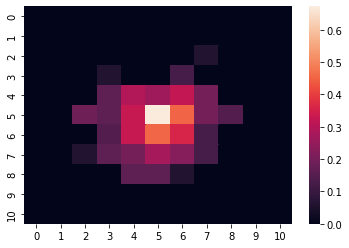

(11, 11)


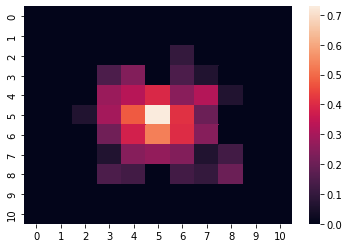

(11, 11)


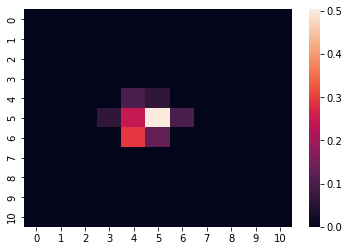

(11, 11)


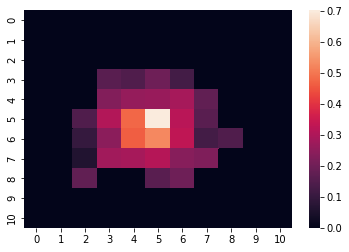

(11, 11)


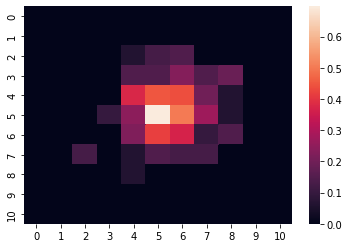

(11, 11)


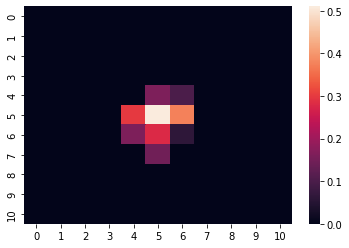

(11, 11)


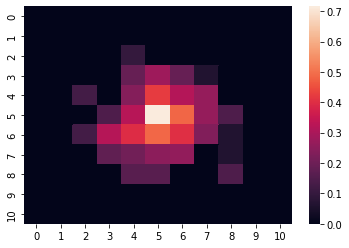

(11, 11)


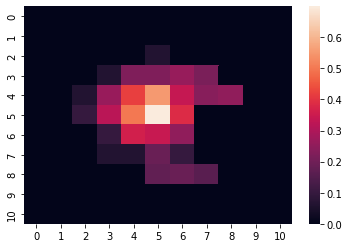

(11, 11)


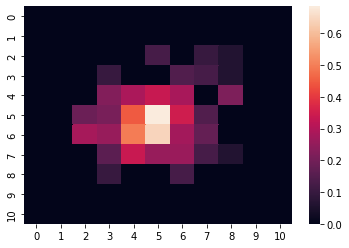

(11, 11)


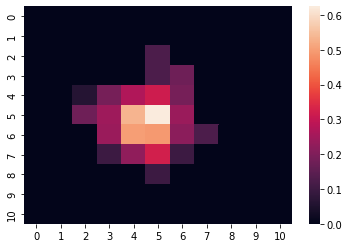

(11, 11)


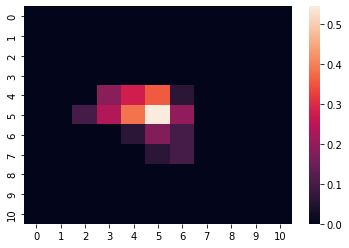

(11, 11)


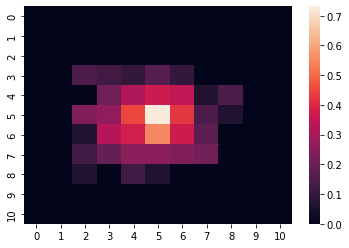

(11, 11)


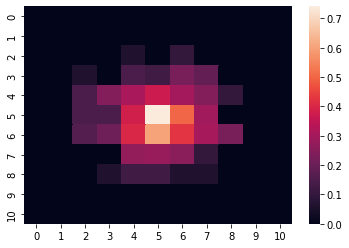

(11, 11)


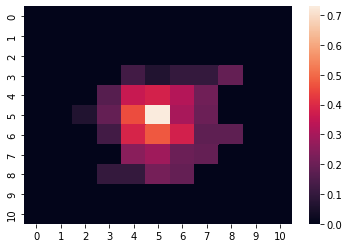

(11, 11)


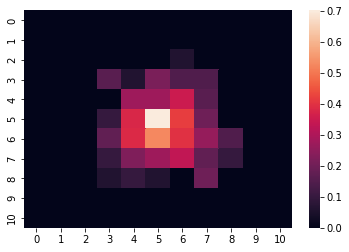

(11, 11)


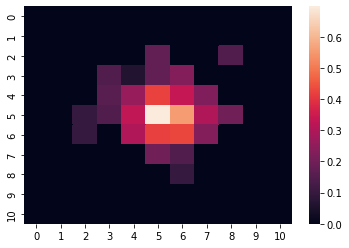

(11, 11)


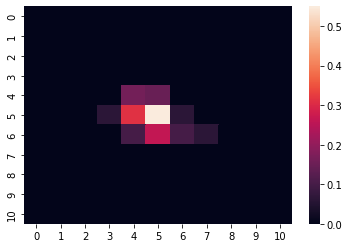

(11, 11)


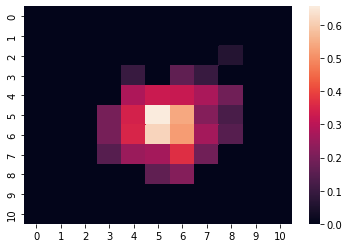

(11, 11)


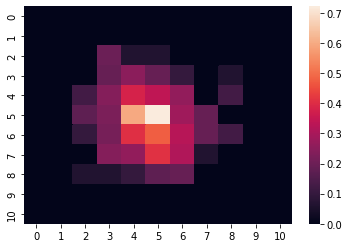

(11, 11)


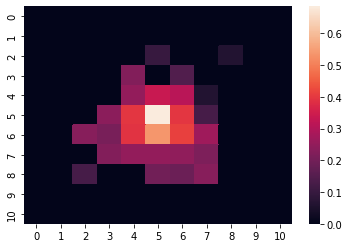

(11, 11)


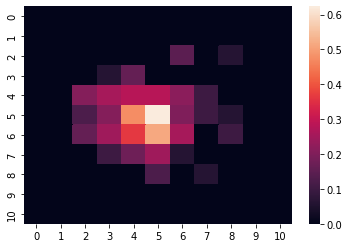

(11, 11)


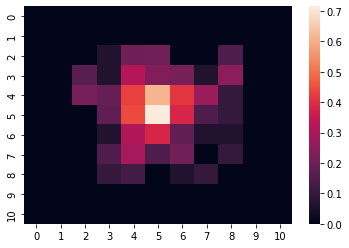

(11, 11)


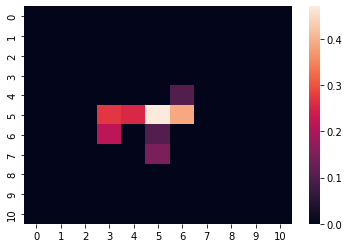

(11, 11)


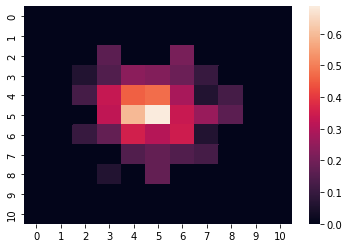

(11, 11)


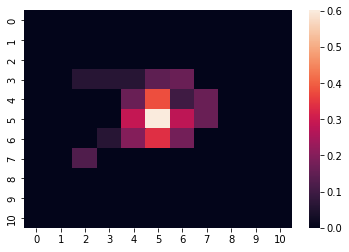

(11, 11)


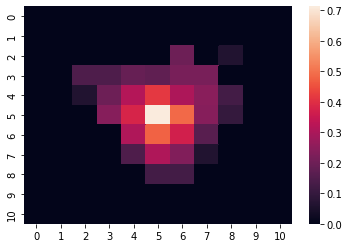

(11, 11)


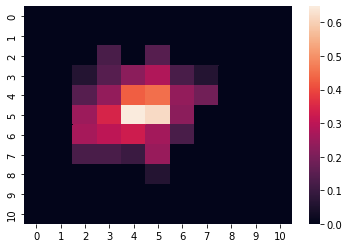

(11, 11)


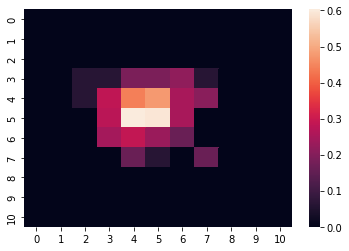

(11, 11)


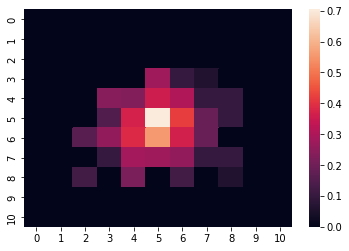

(11, 11)


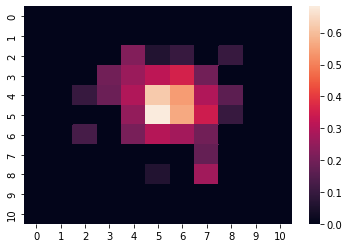

(11, 11)


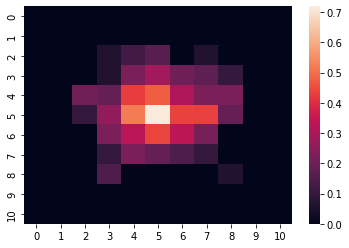

(11, 11)


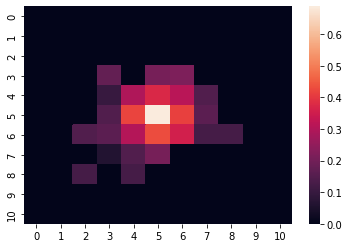

(11, 11)


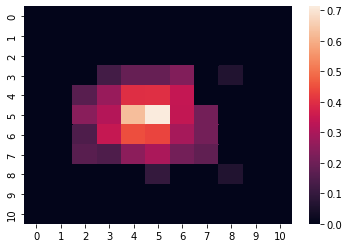

(11, 11)


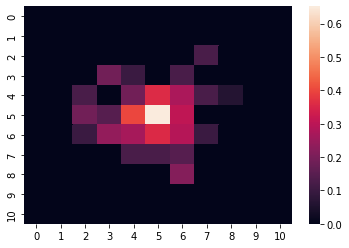

(11, 11)


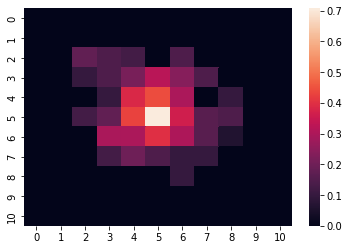

(11, 11)


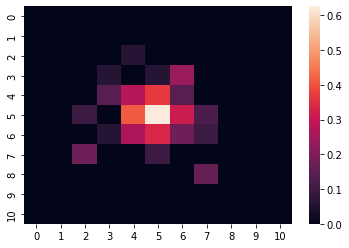

(11, 11)


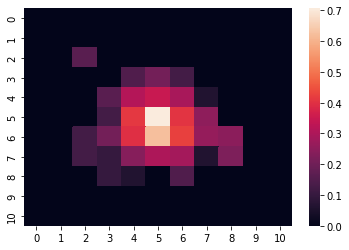

(11, 11)


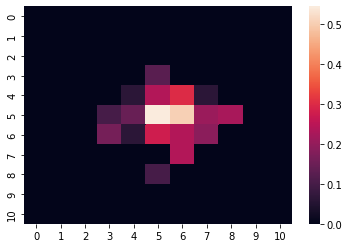

(11, 11)


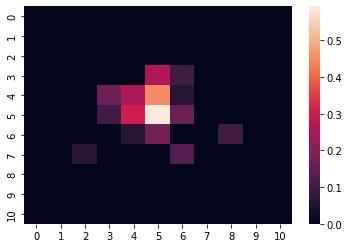

(11, 11)


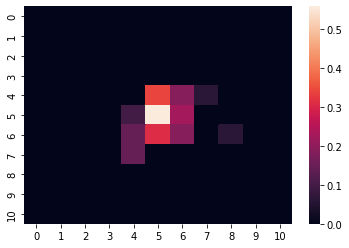

(11, 11)


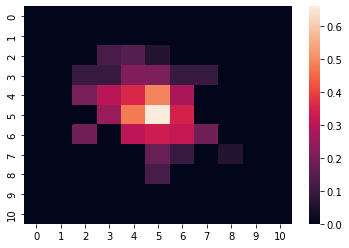

(11, 11)


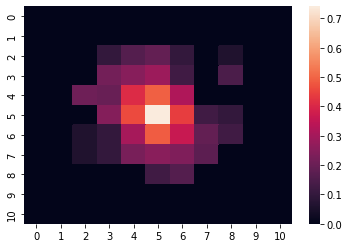

(11, 11)


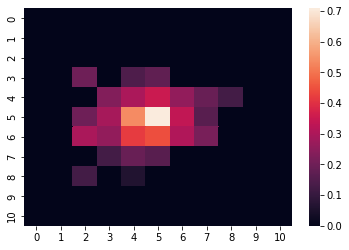

(11, 11)


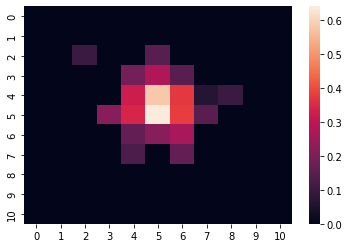

(11, 11)


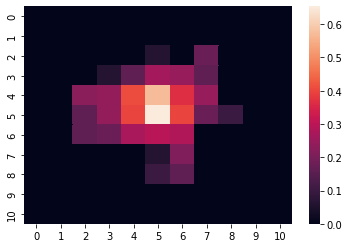

(11, 11)


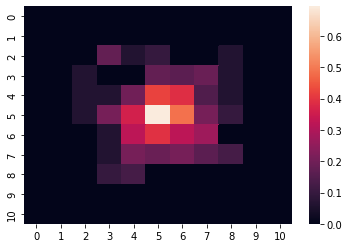

(11, 11)


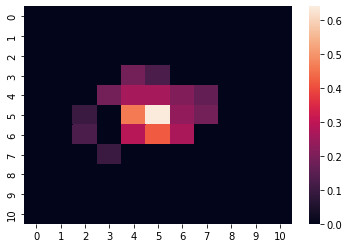

(11, 11)


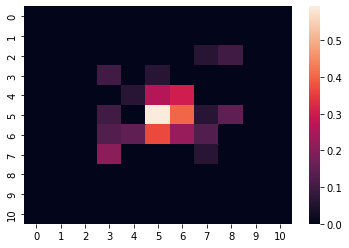

(11, 11)


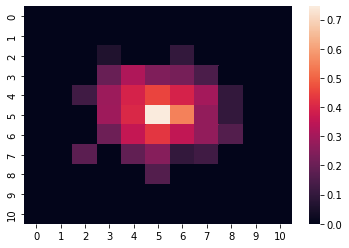

(11, 11)


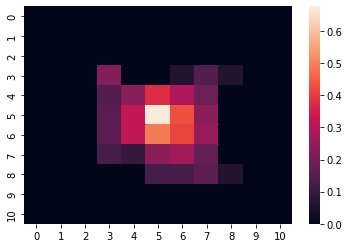

(11, 11)


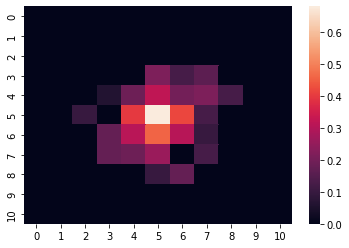

(11, 11)


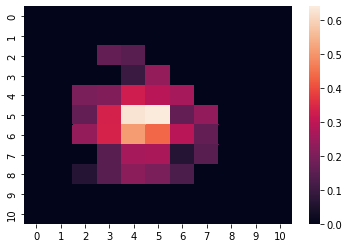

(11, 11)


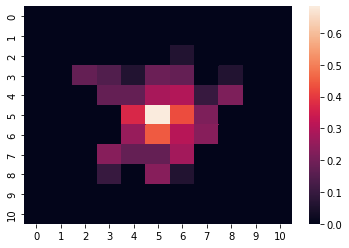

(11, 11)


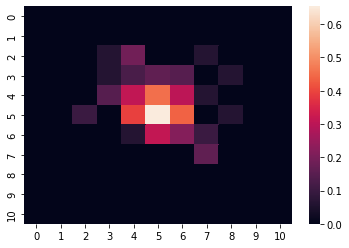

(11, 11)


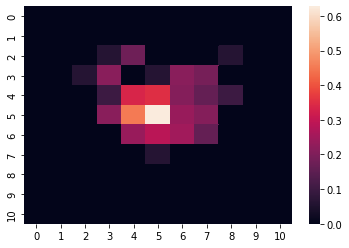

(11, 11)


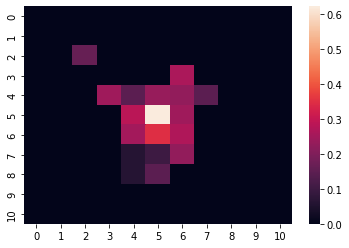

(11, 11)


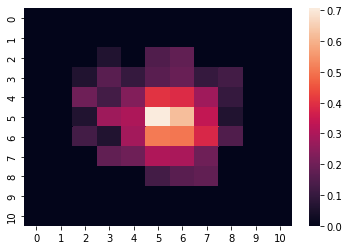

(11, 11)


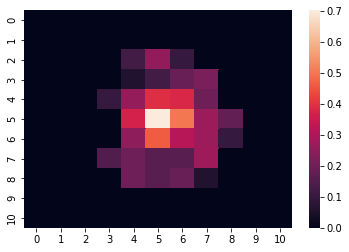

(11, 11)


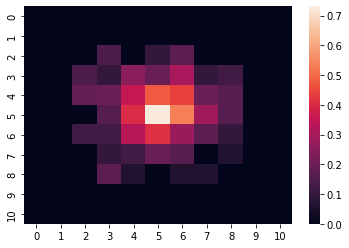

(11, 11)


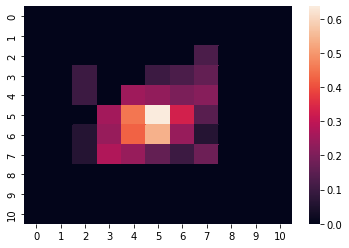

(11, 11)


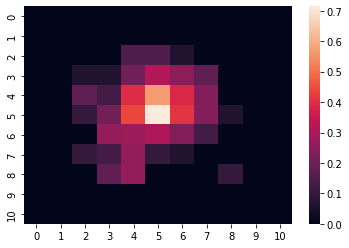

(11, 11)


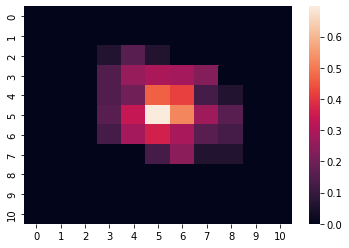

(11, 11)


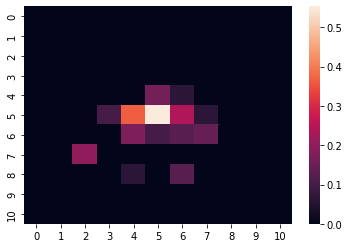

(11, 11)


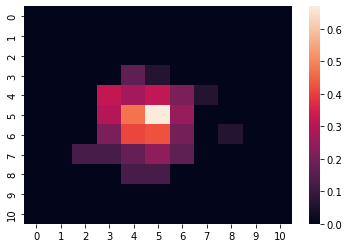

(11, 11)


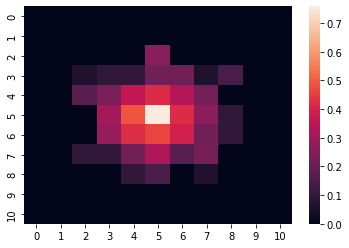

(11, 11)


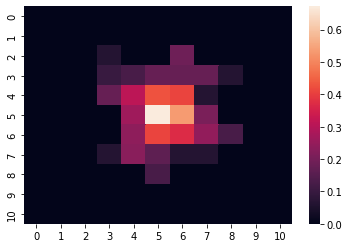

(11, 11)


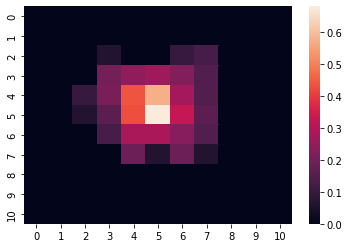

(11, 11)


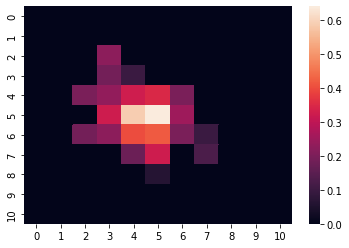

(11, 11)


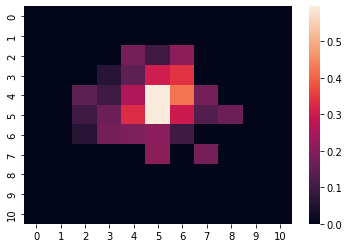

(11, 11)


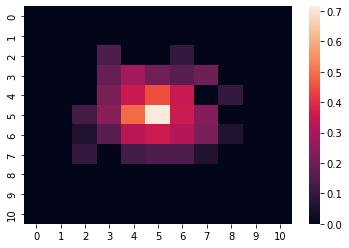

(11, 11)


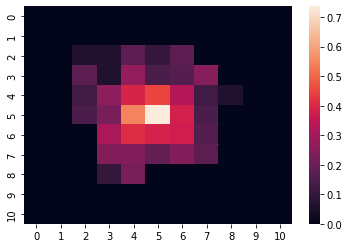

(11, 11)


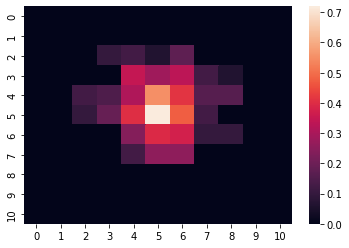

(11, 11)


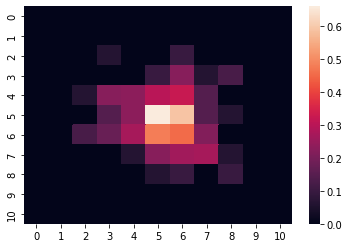

(11, 11)


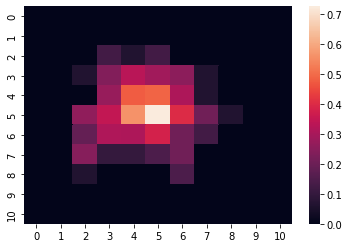

(11, 11)


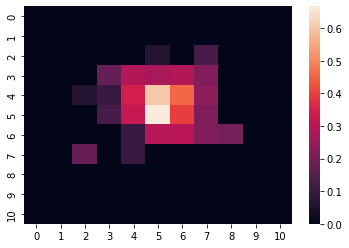

(11, 11)


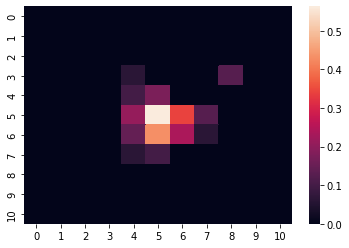

(11, 11)


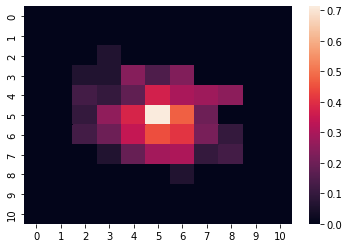

(11, 11)


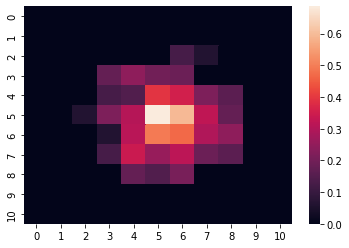

(11, 11)


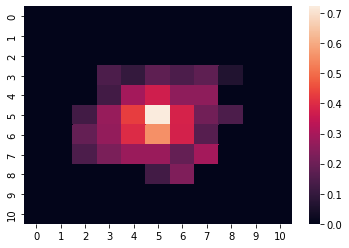

(11, 11)


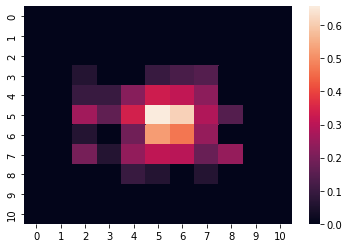

(11, 11)


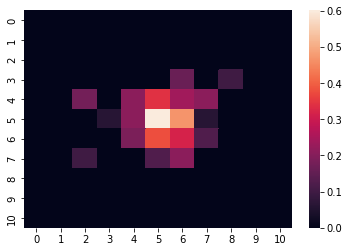

(11, 11)


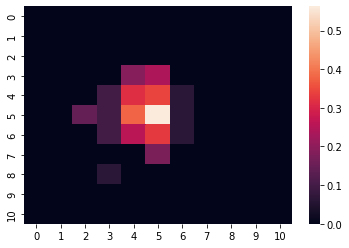

(11, 11)


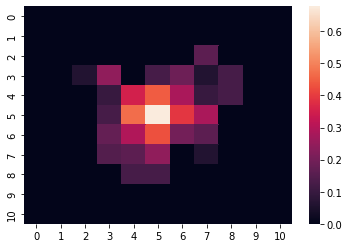

(11, 11)


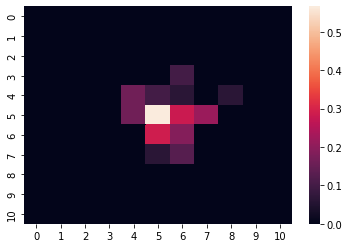

(11, 11)


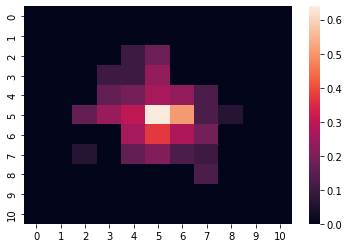

(11, 11)


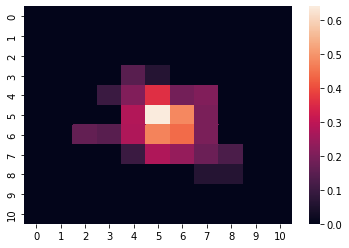

(11, 11)


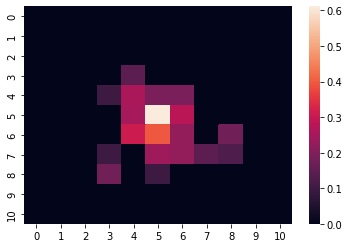

(11, 11)


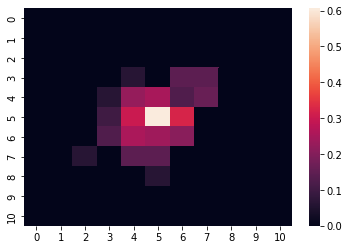

(11, 11)


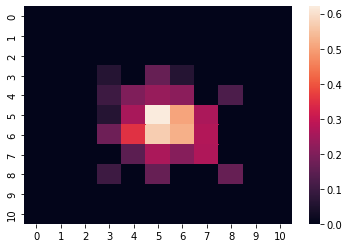

(11, 11)


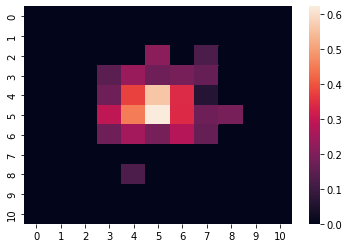

(11, 11)


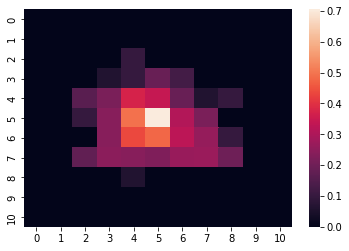

(11, 11)


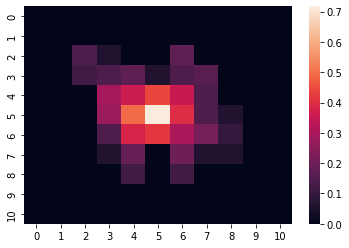

(11, 11)


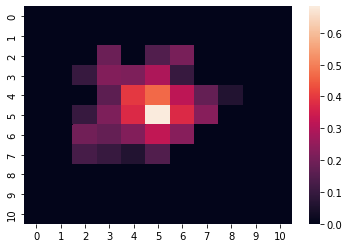

(11, 11)


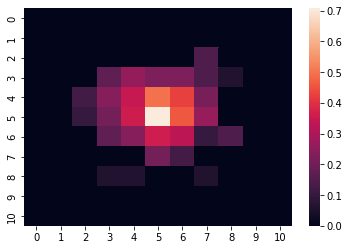

(11, 11)


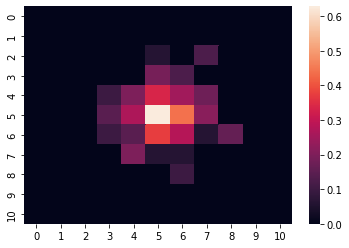

(11, 11)


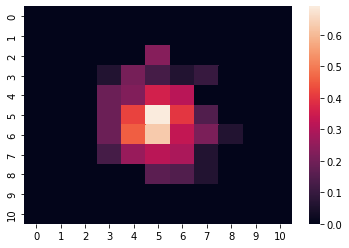

(11, 11)


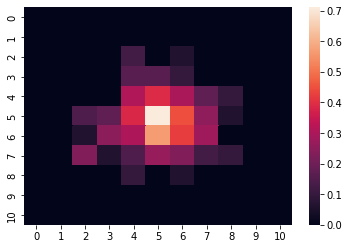

(11, 11)


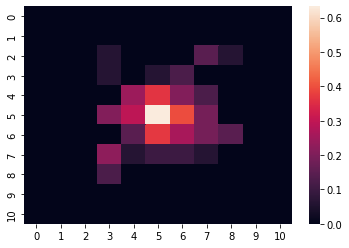

(11, 11)


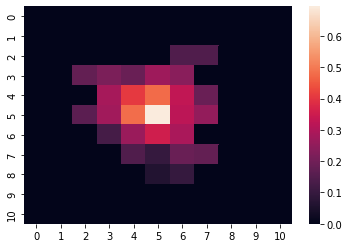

(11, 11)


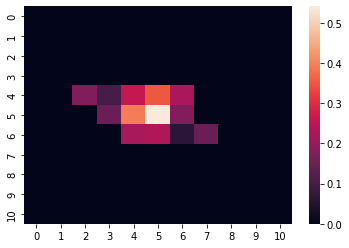

(11, 11)


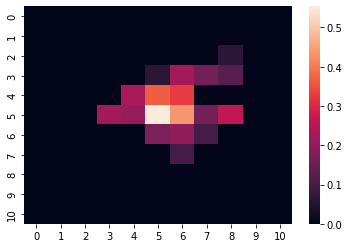

(11, 11)


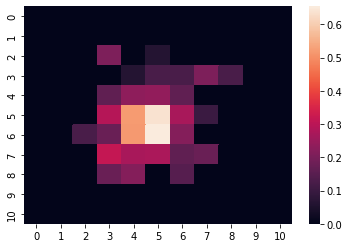

(11, 11)


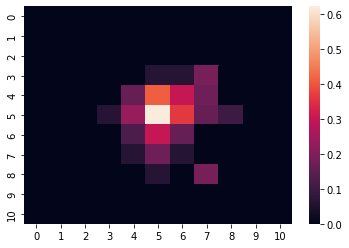

(11, 11)


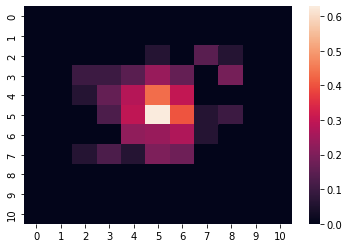

(11, 11)


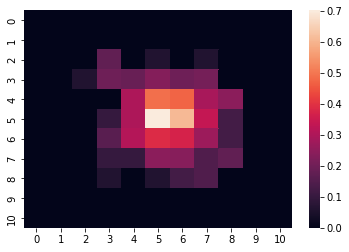

(11, 11)


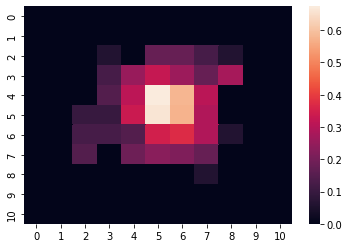

(11, 11)


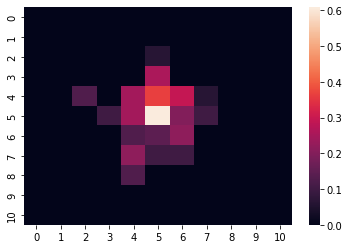

(11, 11)


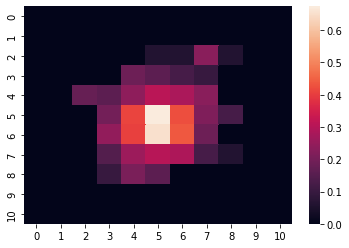

(11, 11)


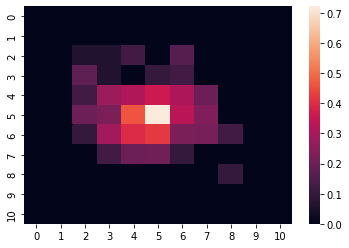

(11, 11)


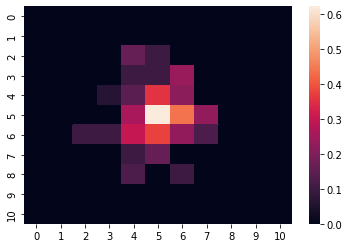

(11, 11)


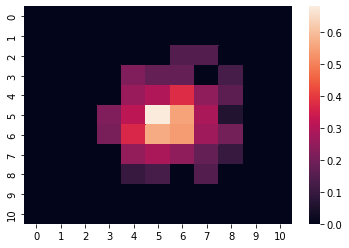

(11, 11)


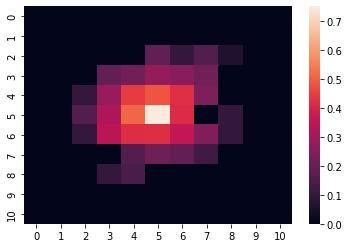

(11, 11)


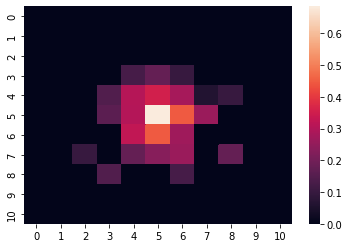

(11, 11)


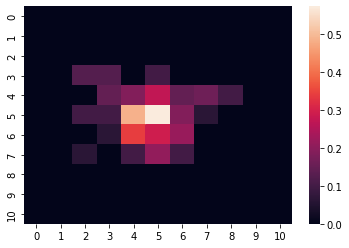

(11, 11)


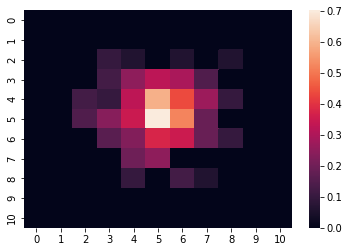

(11, 11)


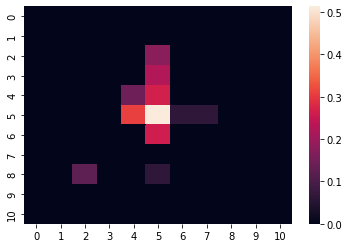

(11, 11)


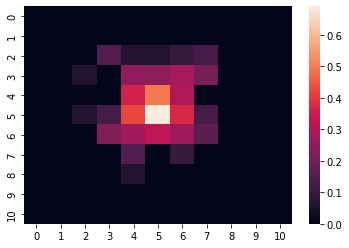

(11, 11)


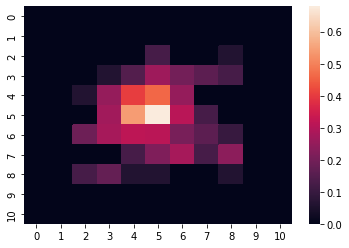

(11, 11)


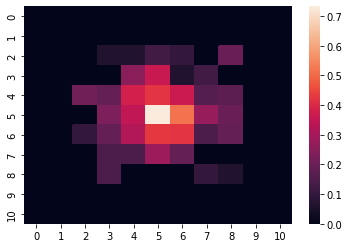

(11, 11)


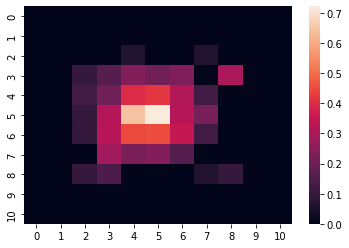

(11, 11)


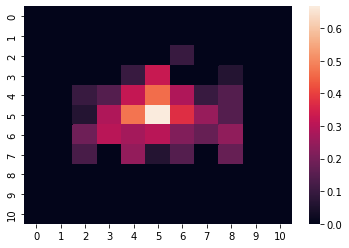

<Figure size 432x288 with 0 Axes>

In [55]:
import os
for i in range(res.shape[0]):
  arr = np.array(df.iloc[[i]])
  arr = np.reshape( arr, (11, 11))
  print(arr.shape)
  hm = sn.heatmap(data = arr)
  name = "result_" + str(i) + ".png"
  plt.show()
  plt.savefig(os.path.join("result_set", name))

In [56]:
!zip -r result_set.zip result_set/ 

  adding: result_set/ (stored 0%)
  adding: result_set/result_91.png (deflated 83%)
  adding: result_set/result_101.png (deflated 83%)
  adding: result_set/result_56.png (deflated 83%)
  adding: result_set/result_33.png (deflated 83%)
  adding: result_set/result_94.png (deflated 83%)
  adding: result_set/result_60.png (deflated 83%)
  adding: result_set/result_105.png (deflated 83%)
  adding: result_set/result_75.png (deflated 83%)
  adding: result_set/result_90.png (deflated 83%)
  adding: result_set/result_49.png (deflated 83%)
  adding: result_set/result_118.png (deflated 83%)
  adding: result_set/result_34.png (deflated 83%)
  adding: result_set/result_80.png (deflated 83%)
  adding: result_set/result_3.png (deflated 83%)
  adding: result_set/result_57.png (deflated 83%)
  adding: result_set/result_23.png (deflated 83%)
  adding: result_set/result_65.png (deflated 83%)
  adding: result_set/result_100.png (deflated 83%)
  adding: result_set/result_61.png (deflated 83%)
  adding: res